In [3]:
import pandas as pd
pd.set_option('display.expand_frame_repr', False)

import matplotlib
import matplotlib.pyplot as plt
font = {'size' : 20}
matplotlib.rc('font', **font)

import seaborn as sns

from pylab import rcParams
rcParams["figure.figsize"] = 30,16

from collections import OrderedDict

import datetime as dt
from datetime import date
from datetime import datetime

import sklearn
from sklearn import metrics
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
import joblib

import numpy as np
np.random.seed(0)
import scipy

import datetime as dt
from datetime import date

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, "../")
import functions

#Funktion für RMSE erstellen
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

## <font size="7">LSTM-1</font><a class="anchor" id="lstm-1"></a>

<font size="5">Es wird zunächst ein simples Netz entwickelt. Das Netz besteht aus einer LSTM-Schicht á 32 Neuronen, die mittels Tanh aktiviert werden. Das Training erfolgt über 50 Epochen mit einer Batchgröße von 16 und einer Lernrate von 0,001. Die Fensterlänge wird initial auf 14 festgelegt.</font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 50
batch_size = 16

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.001)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.41            1.92               1.98
2             2.52            1.95               1.93
3             2.56            1.79               1.82
4             2.33            1.79               2.05
5             2.56            1.85               1.84
Average       2.48            1.86               1.92





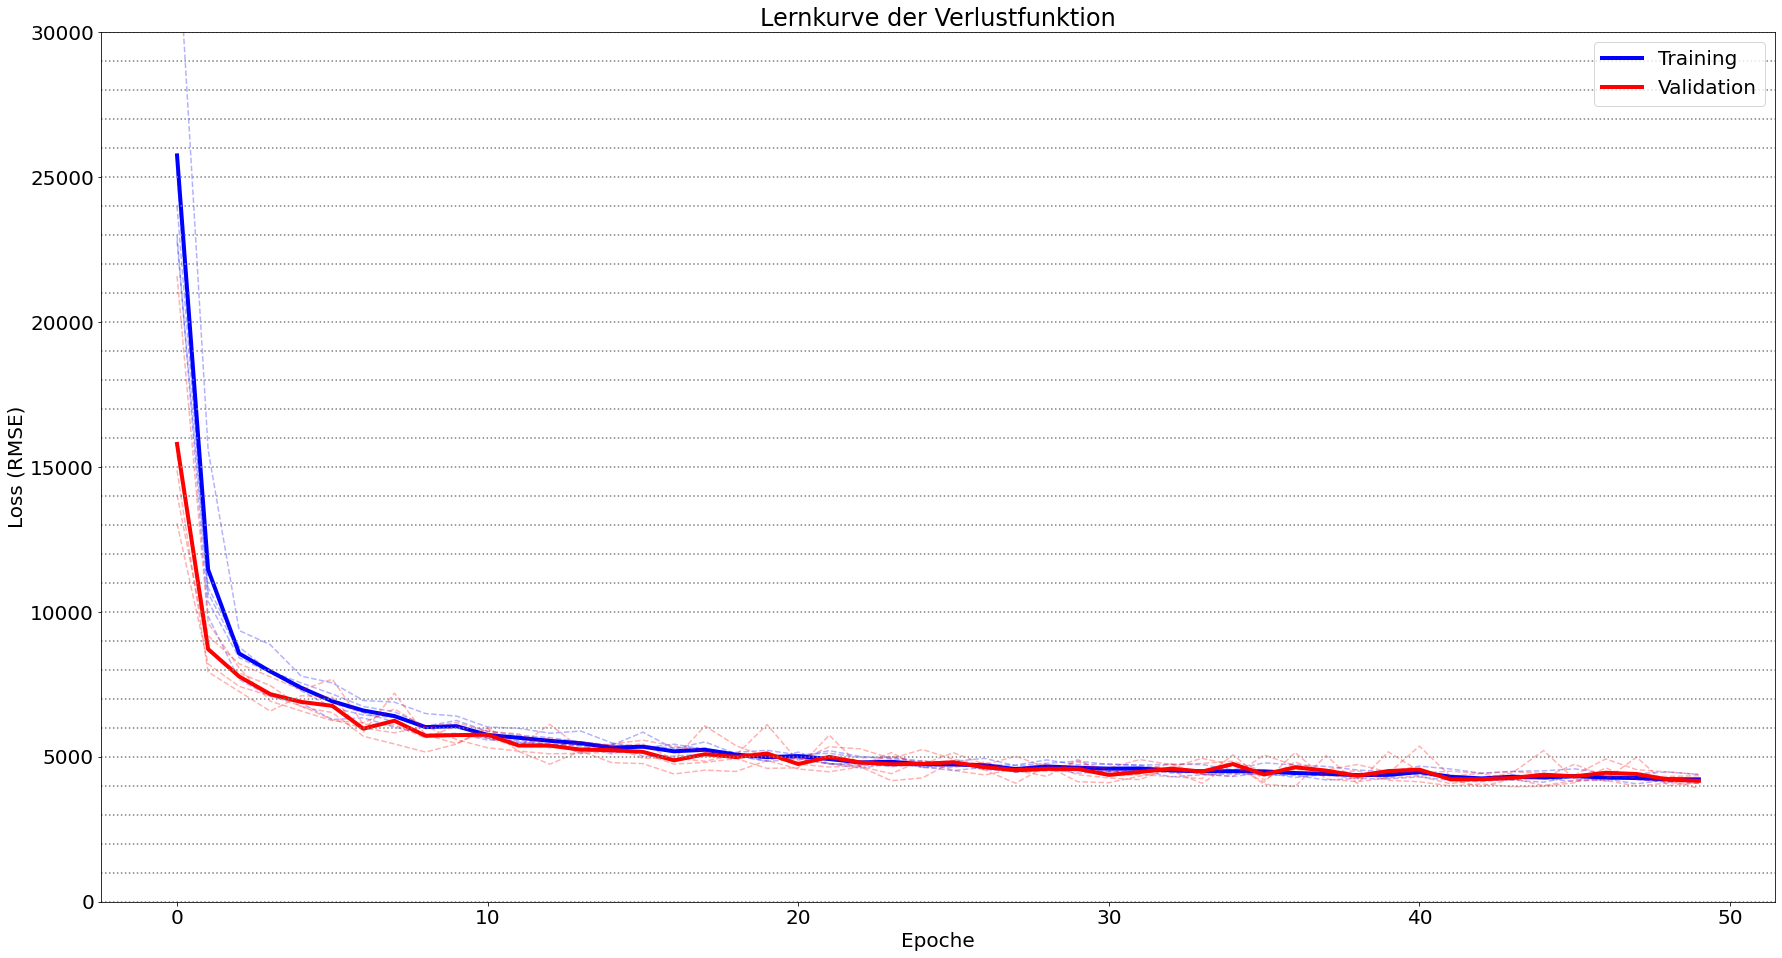

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 30000)

<font size="5">
Das Modell lernt sehr schnell an. In den frühen Epochen wird die Verlustfunktion sehr stark reduziert, ab etwa der 20. Epoche ist der Nutzen je Epoche bereits sehr gering. Ab etwa der 40. Epoche beginnt die Konvergenz des Modells. Das Netz lern sogar so schnell an, dass die Verlustfunktion bei den Validierungsdaten in den ersten 10 Epochen etwas niedriger ist als bei den Trainingsdaten. Ein derartiger Verlauf der Lernkurve lässt auf eine zu hohe Lernrate hindeuten.
 </font>
<br><br>
<font size="5">
Das Modell erreicht auf den Testdaten einen MAPE von etwa 2,39%, im Vergleich dazu wird auf den Trainingsdaten 1,89% erreicht. Neben der möglicherweise zu hohen Lernrate liegt also außerdem eine leichte Überanpassung vor.
</font>


### <font size="5">Test</font>

In [10]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/50
137/137 [==============================] - 2s 4ms/step - loss: 0.1664
Epoch 2/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0676
Epoch 3/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0607
Epoch 4/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0561
Epoch 5/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0525
Epoch 6/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0507
Epoch 7/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0488
Epoch 8/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0471
Epoch 9/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0462
Epoch 10/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0447
Epoch 11/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0440
Epoch 12/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0430
Epoch 13/50
137/137 [====

       Testdaten Trainingsdaten
R2          0.96           0.97
MAE       3957.0         3010.0
MSE   28446877.0     20092047.0
RMSE      5334.0         4482.0
                               
MAPE      2.39 %         1.89 %


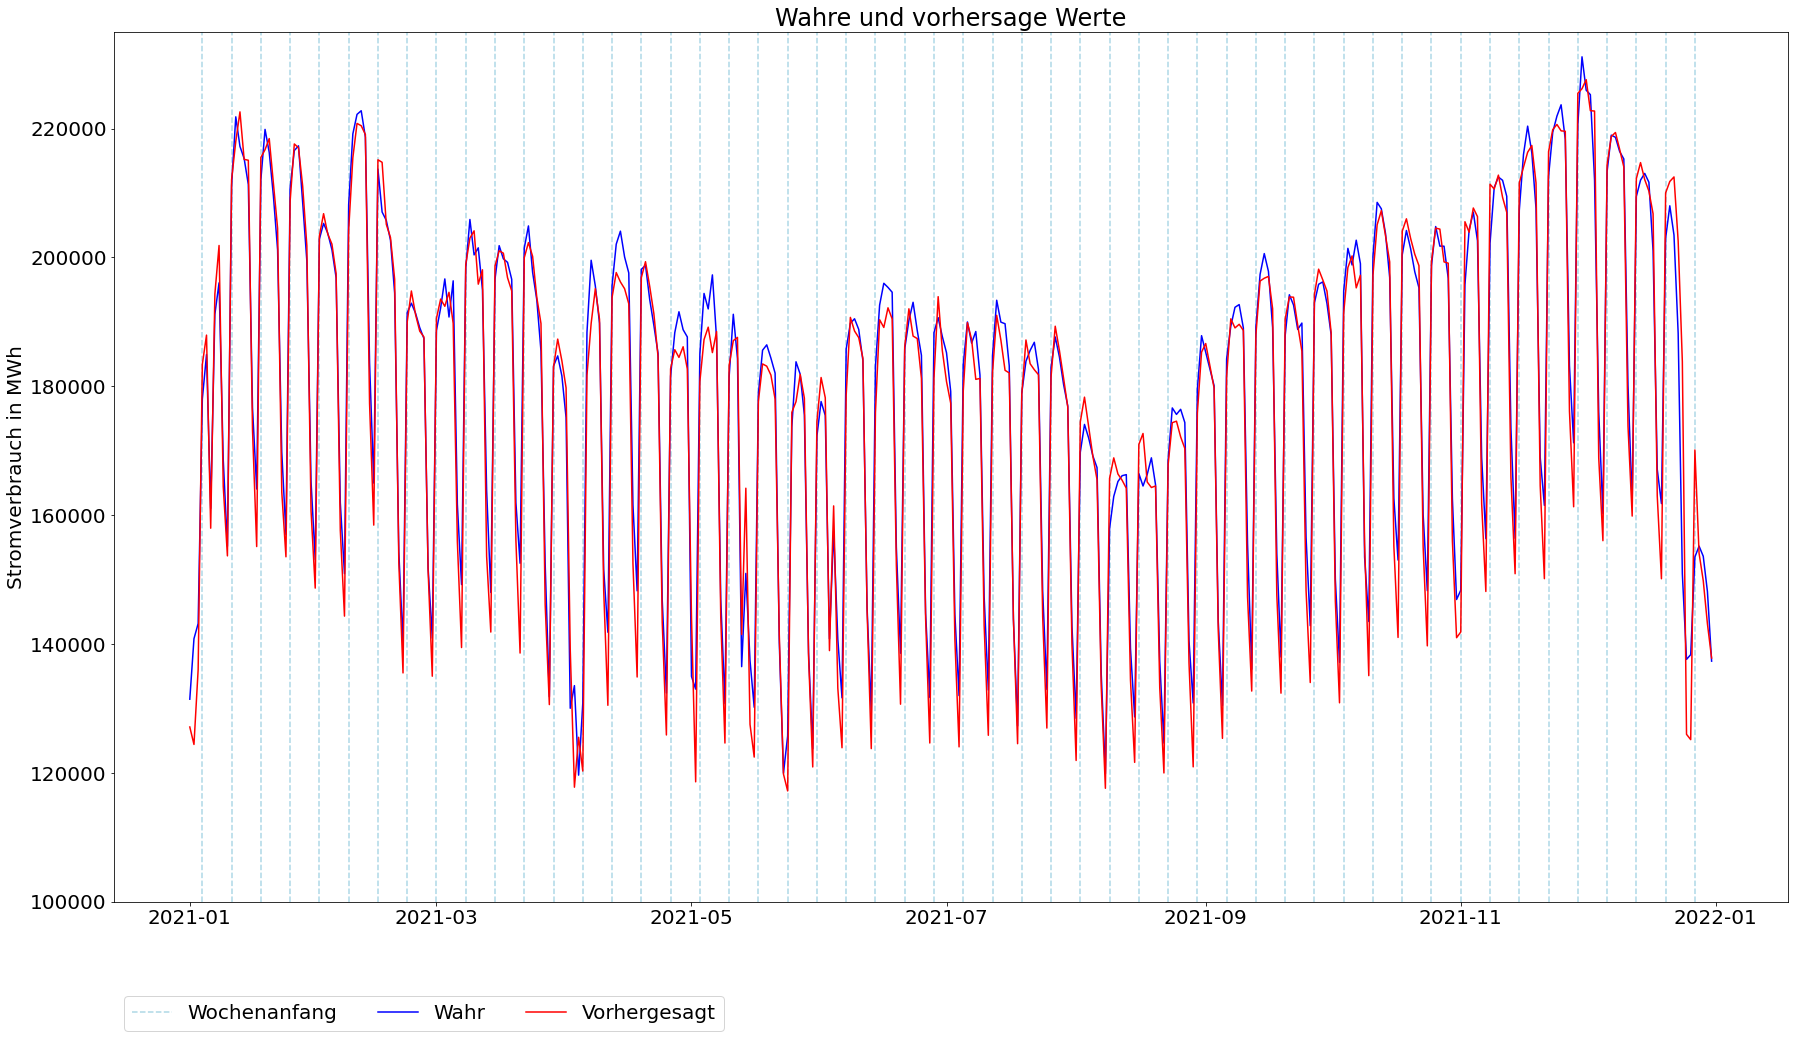

In [11]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

# <font size="7">LSTM-2</font><a class="anchor" id="lstm-2"></a>

<font size="5">Es wird also zunächst versucht, die Lernrate etwas zu senken. Dafür wird die Lernrate von 0,001 auf 0,0005 gesenkt.</font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 50
batch_size = 16

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.55            2.10               2.17
2             2.66            1.94               1.93
3             2.45            1.92               1.98
4             2.59            2.03               2.21
5             2.30            2.05               1.95
Average       2.51            2.01               2.05





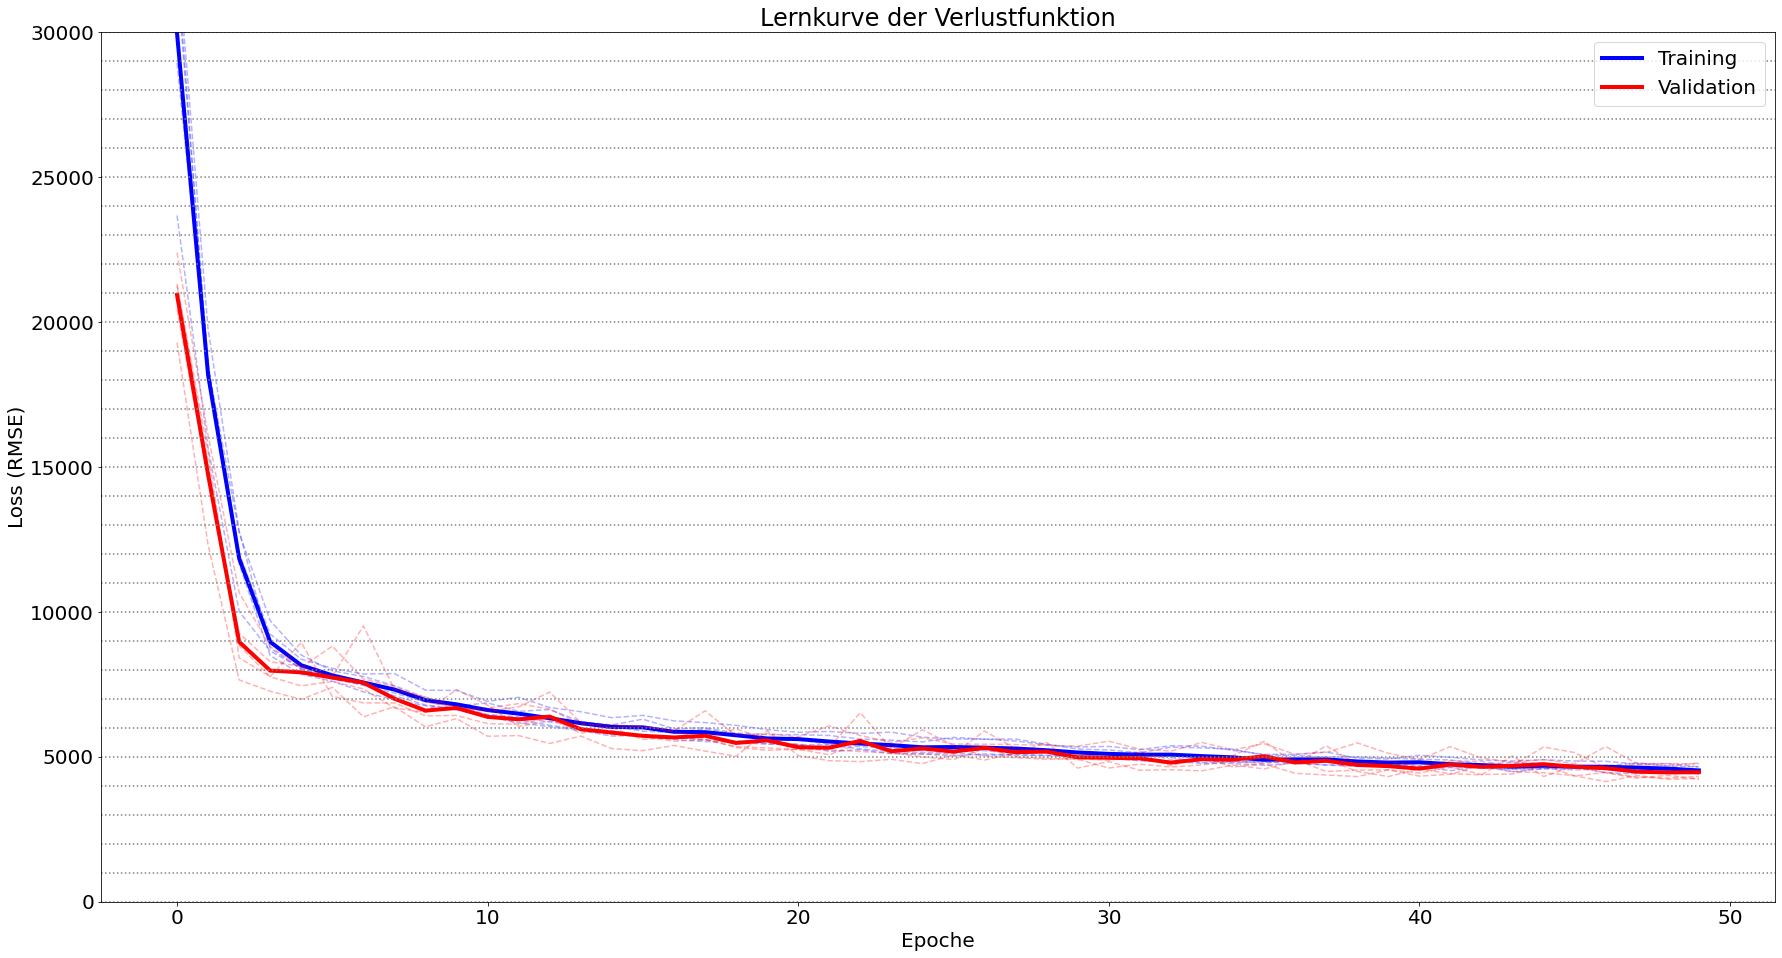

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 30000)

<font size="5">
Das Netz verhält sich beim Training mit der etwas niedrigeren Lernrate immer noch ähnlich, allerdings setzt die Konvergenz scheinbar etwas später ein. Die Anzahl an Epochen sollte bei einer geringeren Lernrate also erhöht werden.
 </font>
<br><br>
<font size="5">
Das Modell hat sich trotzdem insgesamt etwas verbessert. Der MAPE fällt bei den Testdaten auf 2,2%, steigt dafür aber auf den Trainingsdaten auf 2,04%. Die Überanpassung wurde also bereits teilweise behoben.</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/50
137/137 [==============================] - 2s 4ms/step - loss: 0.2612
Epoch 2/50
137/137 [==============================] - 1s 4ms/step - loss: 0.1292
Epoch 3/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0795
Epoch 4/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0691
Epoch 5/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0644
Epoch 6/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0623
Epoch 7/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0578
Epoch 8/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0548
Epoch 9/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0554
Epoch 10/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0522
Epoch 11/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0499
Epoch 12/50
137/137 [==============================] - 1s 4ms/step - loss: 0.0497
Epoch 13/50
137/137 [====

       Testdaten Trainingsdaten
R2          0.96           0.97
MAE       3737.0         3201.0
MSE   24844483.0     21776703.0
RMSE      4984.0         4667.0
                               
MAPE       2.2 %         2.04 %


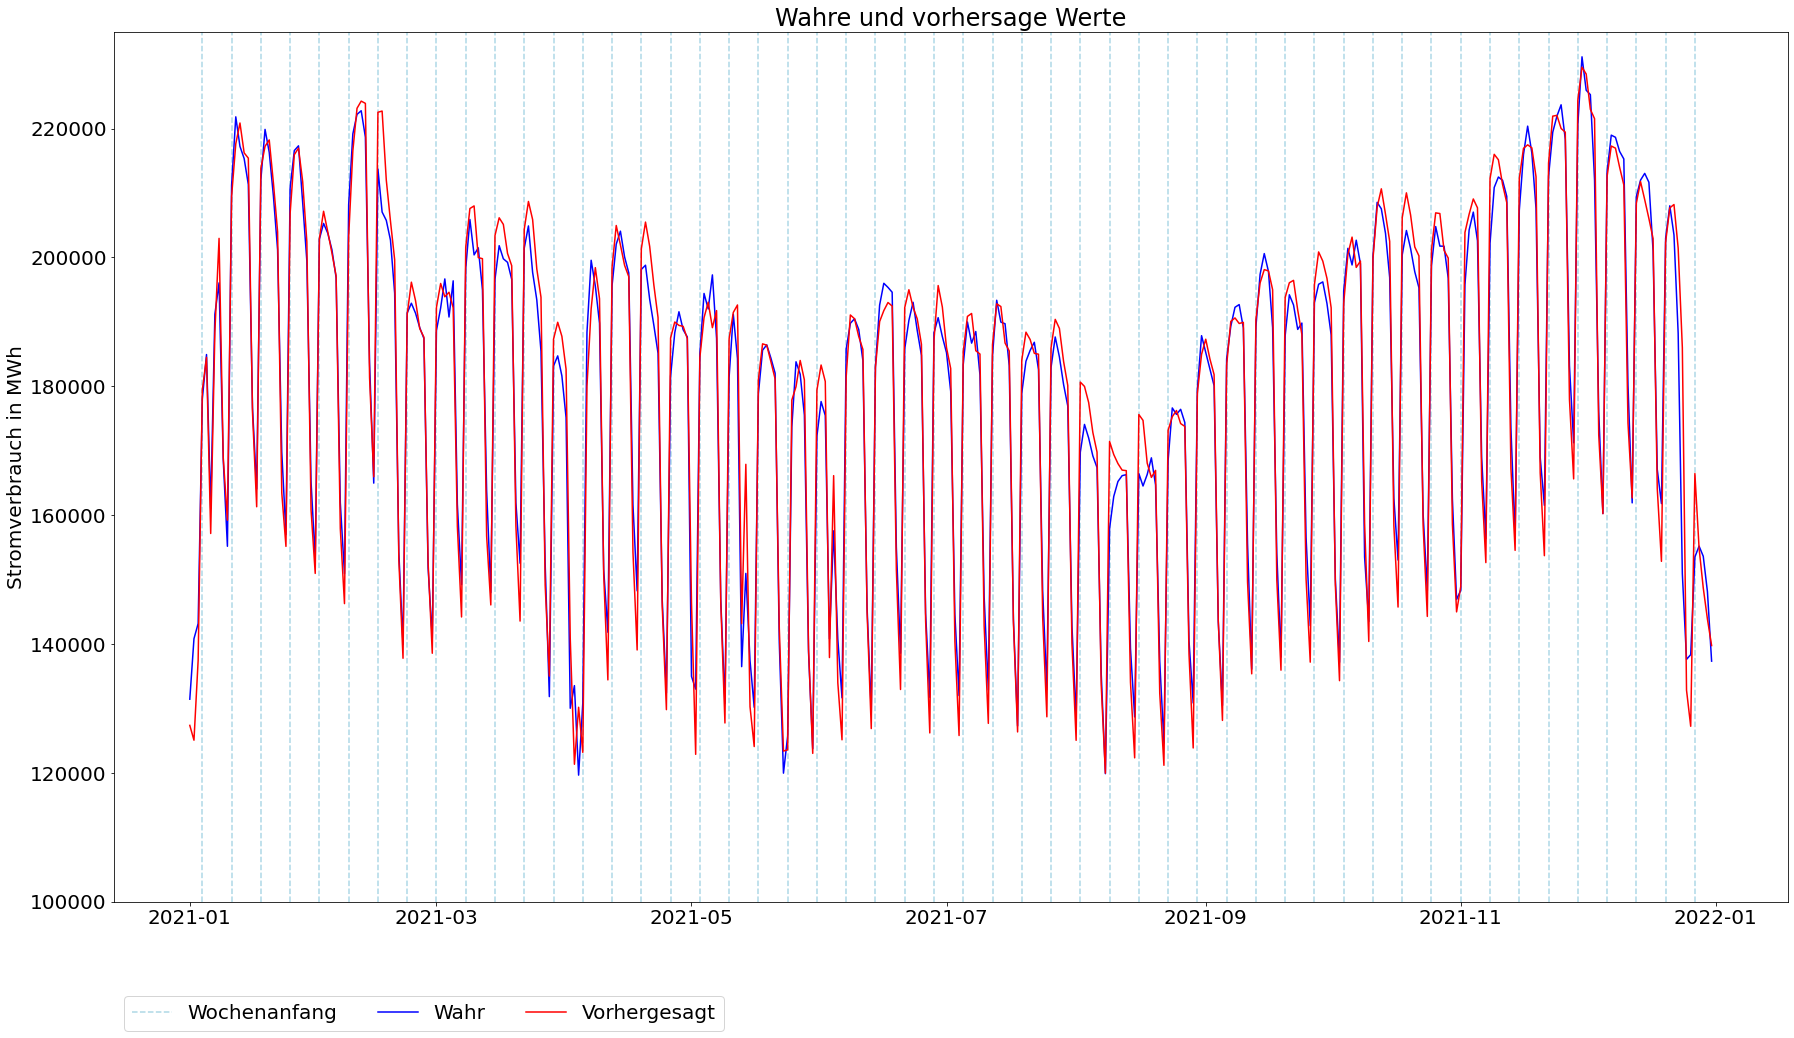

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-3</font><a class="anchor" id="lstm-3"></a>

<font size="5">Da einer verringerte Lernrate das Modell verbessert und auch die Überanpassung vermindert, wird eine noch niedrigere Lernrate ausprobiert. Sie wird von 0,0005 auf 0,0001 gesenkt.</font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 75
batch_size = 16

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0001)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             3.09            2.99               3.11
2             2.79            2.83               2.75
3             2.49            2.59               2.62
4             2.63            2.72               2.99
5             2.53            2.58               2.47
Average       2.71            2.74               2.79





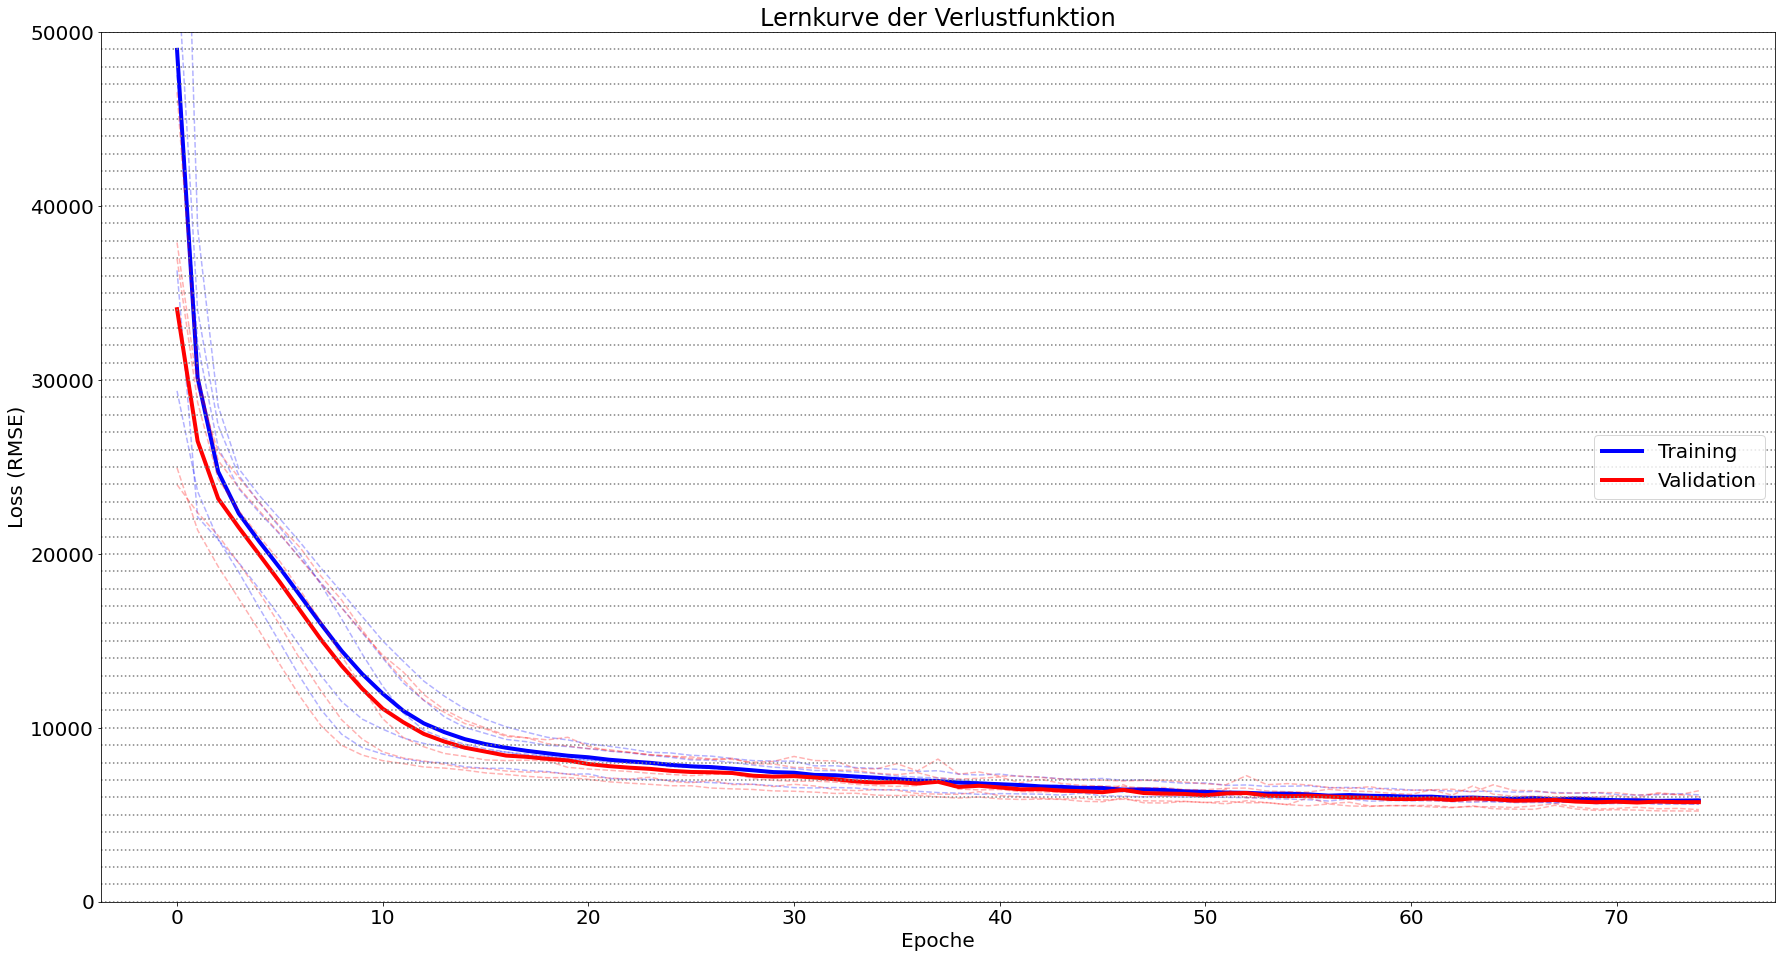

In [8]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 50000)

<font size="5">
Das Netz lernt zu Beginn nun sehr viel langsamer, die Konvergenz setzt erwartungsgemäß erst nach mehr Epochen ein. Das Training sollte also möglicherweise etwas verlängert werden. Es scheint zunächst nicht zu Überanpassungen zu kommen. Allerdings sind die Verlustfunktionen etwas höher.
 </font>
<br><br>
<font size="5">
Das Modell hat sich durch die sehr niedrigere Lernrate erheblich verschlechtert. Der Abstand des MAPE auf Trainings- und Testdaten hat sich verringert, die Überanpassung nimmt also weiter ab. Allerdings scheint es eher zu einer Unteranpassung zu kommen, da das Modell sehr schlecht abschneidet.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/75
137/137 [==============================] - 2s 4ms/step - loss: 0.3093
Epoch 2/75
137/137 [==============================] - 1s 4ms/step - loss: 0.1910
Epoch 3/75
137/137 [==============================] - 1s 4ms/step - loss: 0.1724
Epoch 4/75
137/137 [==============================] - 1s 4ms/step - loss: 0.1584
Epoch 5/75
137/137 [==============================] - 1s 5ms/step - loss: 0.1414
Epoch 6/75
137/137 [==============================] - 1s 4ms/step - loss: 0.1237
Epoch 7/75
137/137 [==============================] - 1s 4ms/step - loss: 0.1058
Epoch 8/75
137/137 [==============================] - 1s 4ms/step - loss: 0.0892
Epoch 9/75
137/137 [==============================] - 1s 4ms/step - loss: 0.0789
Epoch 10/75
137/137 [==============================] - 1s 4ms/step - loss: 0.0723
Epoch 11/75
137/137 [==============================] - 1s 4ms/step - loss: 0.0701
Epoch 12/75
137/137 [==============================] - 1s 4ms/step - loss: 0.0686
Epoch 13/75
137/137 [====

       Testdaten Trainingsdaten
R2          0.94           0.95
MAE       4602.0         4097.0
MSE   38403103.0     33892941.0
RMSE      6197.0         5822.0
                               
MAPE       2.7 %         2.57 %


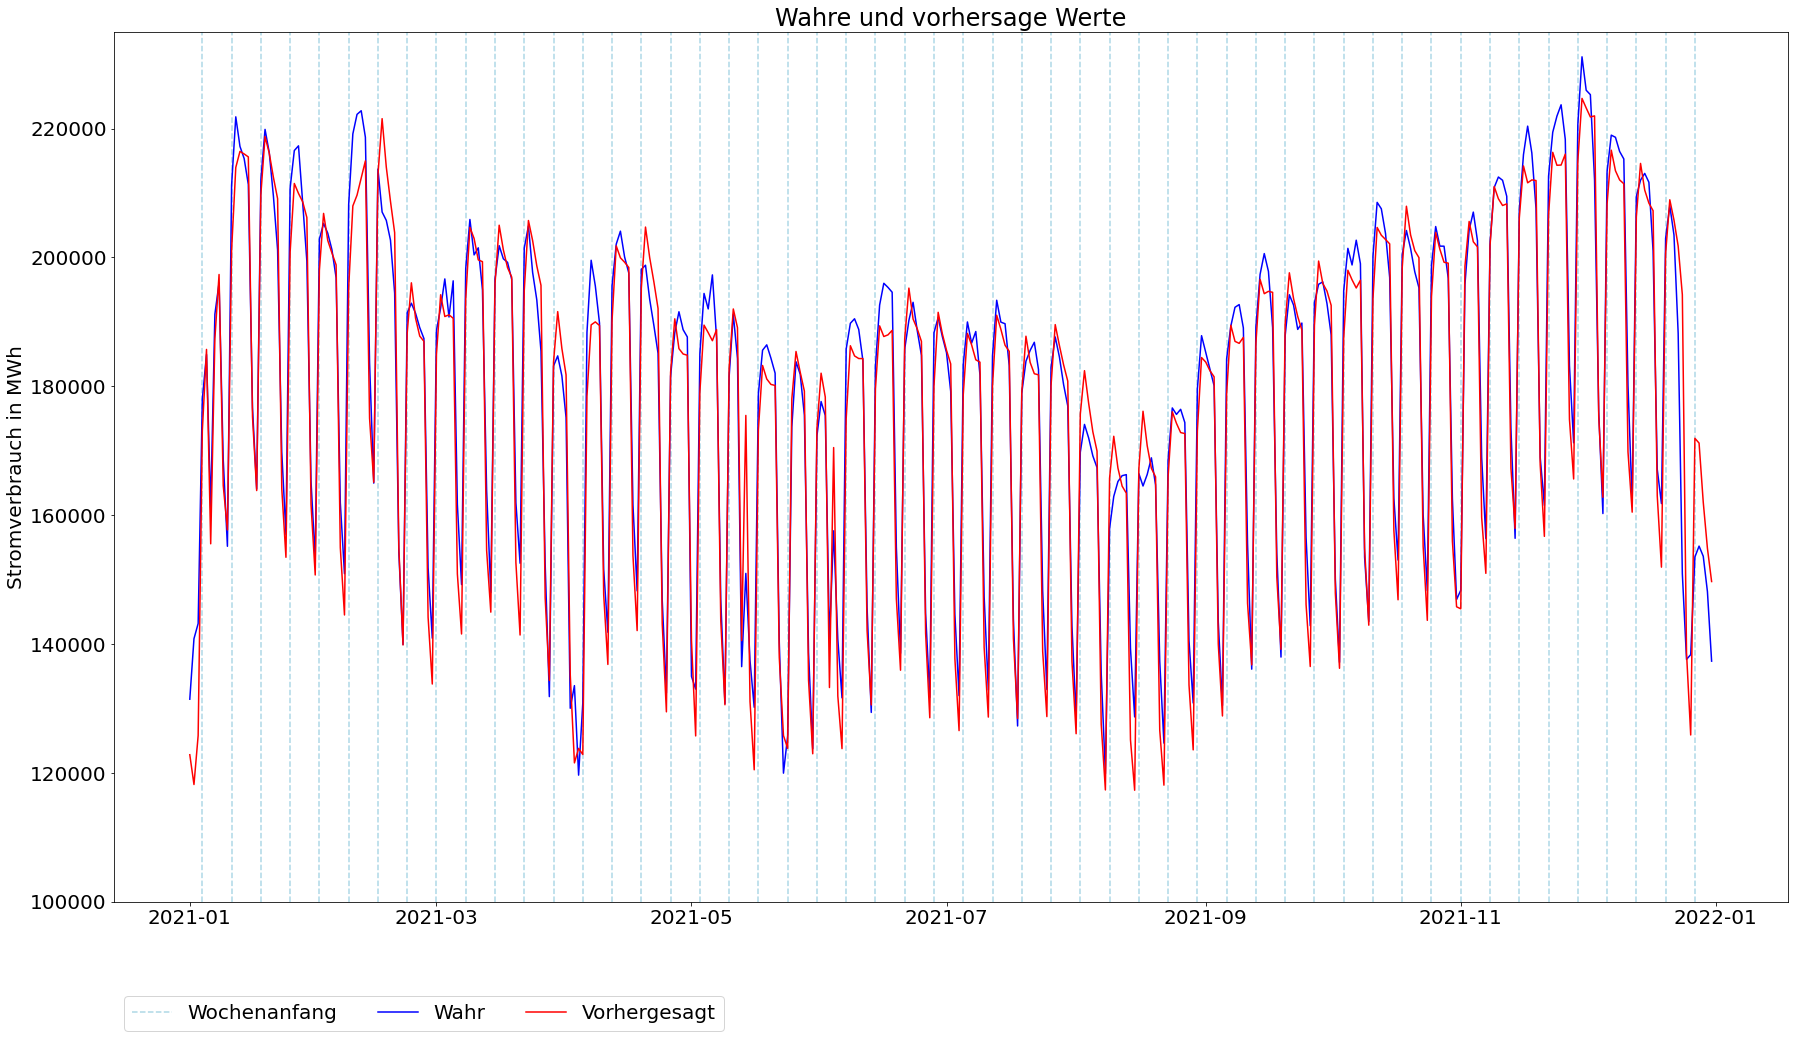

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-4</font><a class="anchor" id="lstm-4"></a>

<font size="5">Die Lernrate wird wieder auf 0,005 festgelegt, da sich hier gute Ergebnisse erzielen ließen. Im nächsten Verusch werden die Batches von 16 auf 32 erhöht, um sicherzustellen, dass die Verlustfunktion nicht in einem lokalen Minimum hängen bleibt.</font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 75
batch_size = 32

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.58            2.17               2.20
2             2.42            2.04               1.98
3             2.36            2.13               2.17
4             2.70            2.19               2.44
5             2.29            2.30               2.17
Average       2.47            2.17               2.19





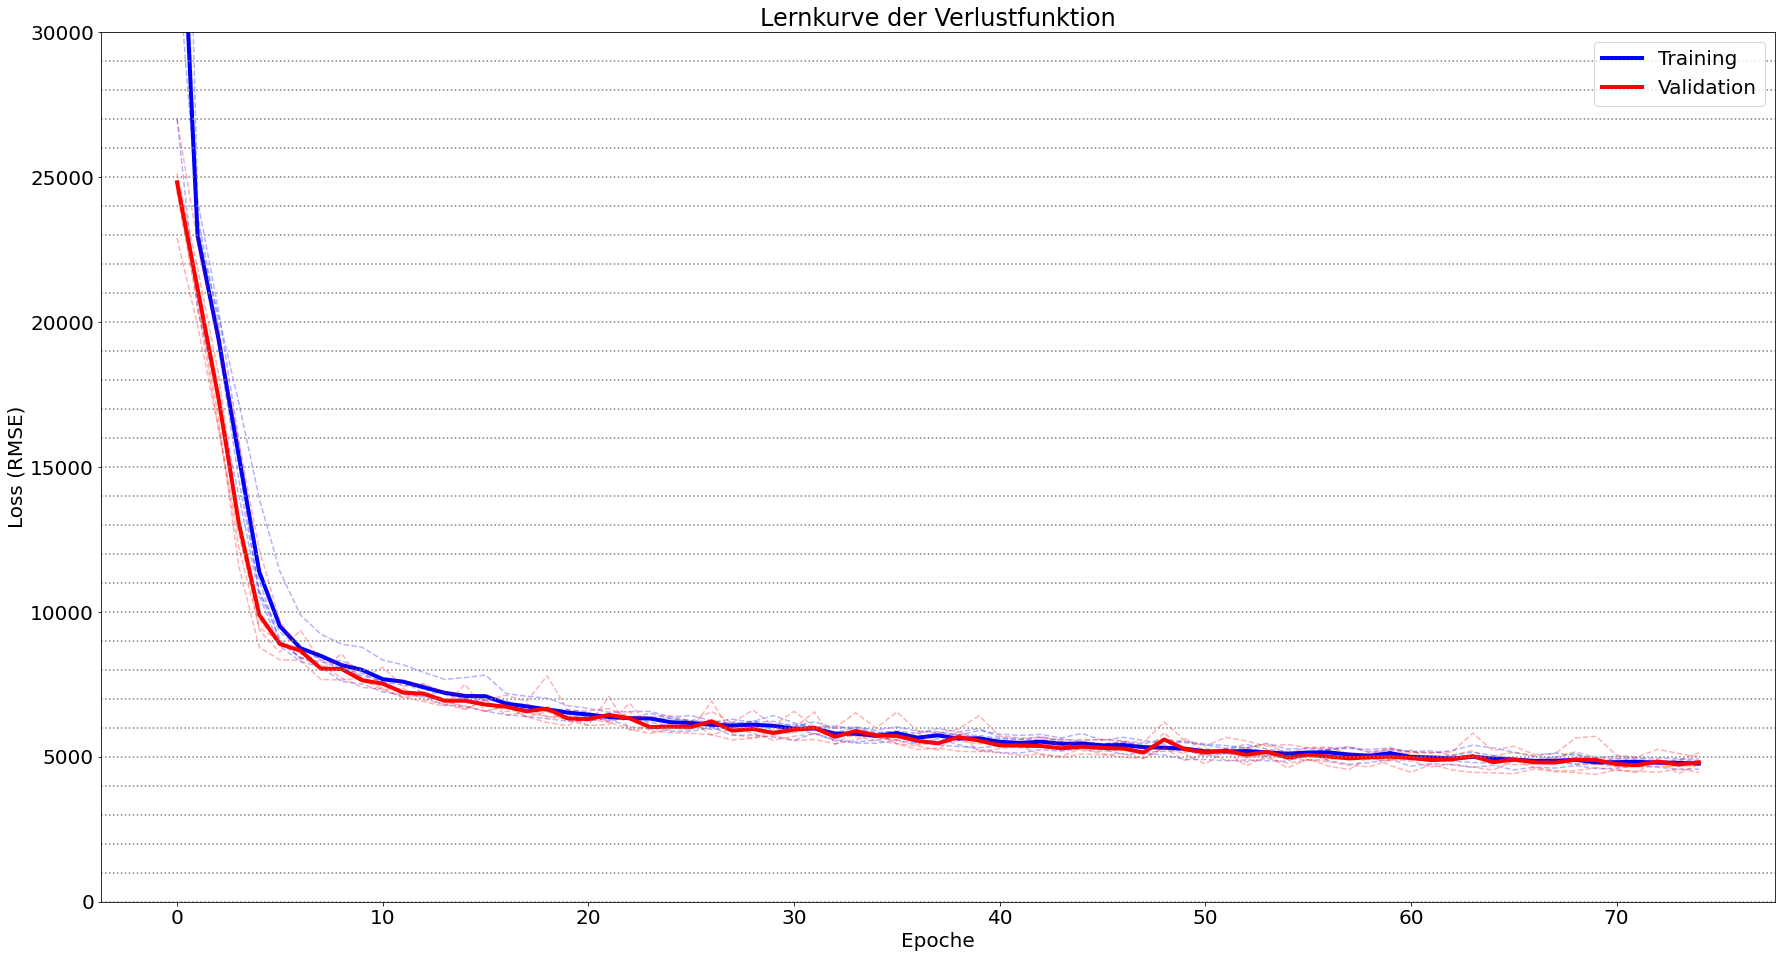

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 30000)

<font size="5">
Wie schon bei LSTM-2 lernt das Modell sehr schnell und die Konvergenz setzt etwas früher ein.
 </font>
<br><br>
<font size="5">
Im Vergleich zu LSTM-2 lassen sich der MAPE auf den Trainings- und Testdaten jedoch nicht wirklich verbessern. Bei den Testdaten setzt sogar eine leichte Verschlechterung ein, was auf eine leichte Überanpassung deuten könnte.
</font>

### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/75
69/69 [==============================] - 2s 4ms/step - loss: 0.3148
Epoch 2/75
69/69 [==============================] - 0s 4ms/step - loss: 0.1612
Epoch 3/75
69/69 [==============================] - 0s 4ms/step - loss: 0.1234
Epoch 4/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0806
Epoch 5/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0671
Epoch 6/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0631
Epoch 7/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0607
Epoch 8/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0606
Epoch 9/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0573
Epoch 10/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0560
Epoch 11/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0549
Epoch 12/75
69/69 [==============================] - 0s 4ms/step - loss: 0.0535
Epoch 13/75
69/69 [==============================

       Testdaten Trainingsdaten
R2          0.96           0.97
MAE       4060.0         3212.0
MSE   29637490.0     22783486.0
RMSE      5444.0         4773.0
                               
MAPE      2.42 %         2.03 %


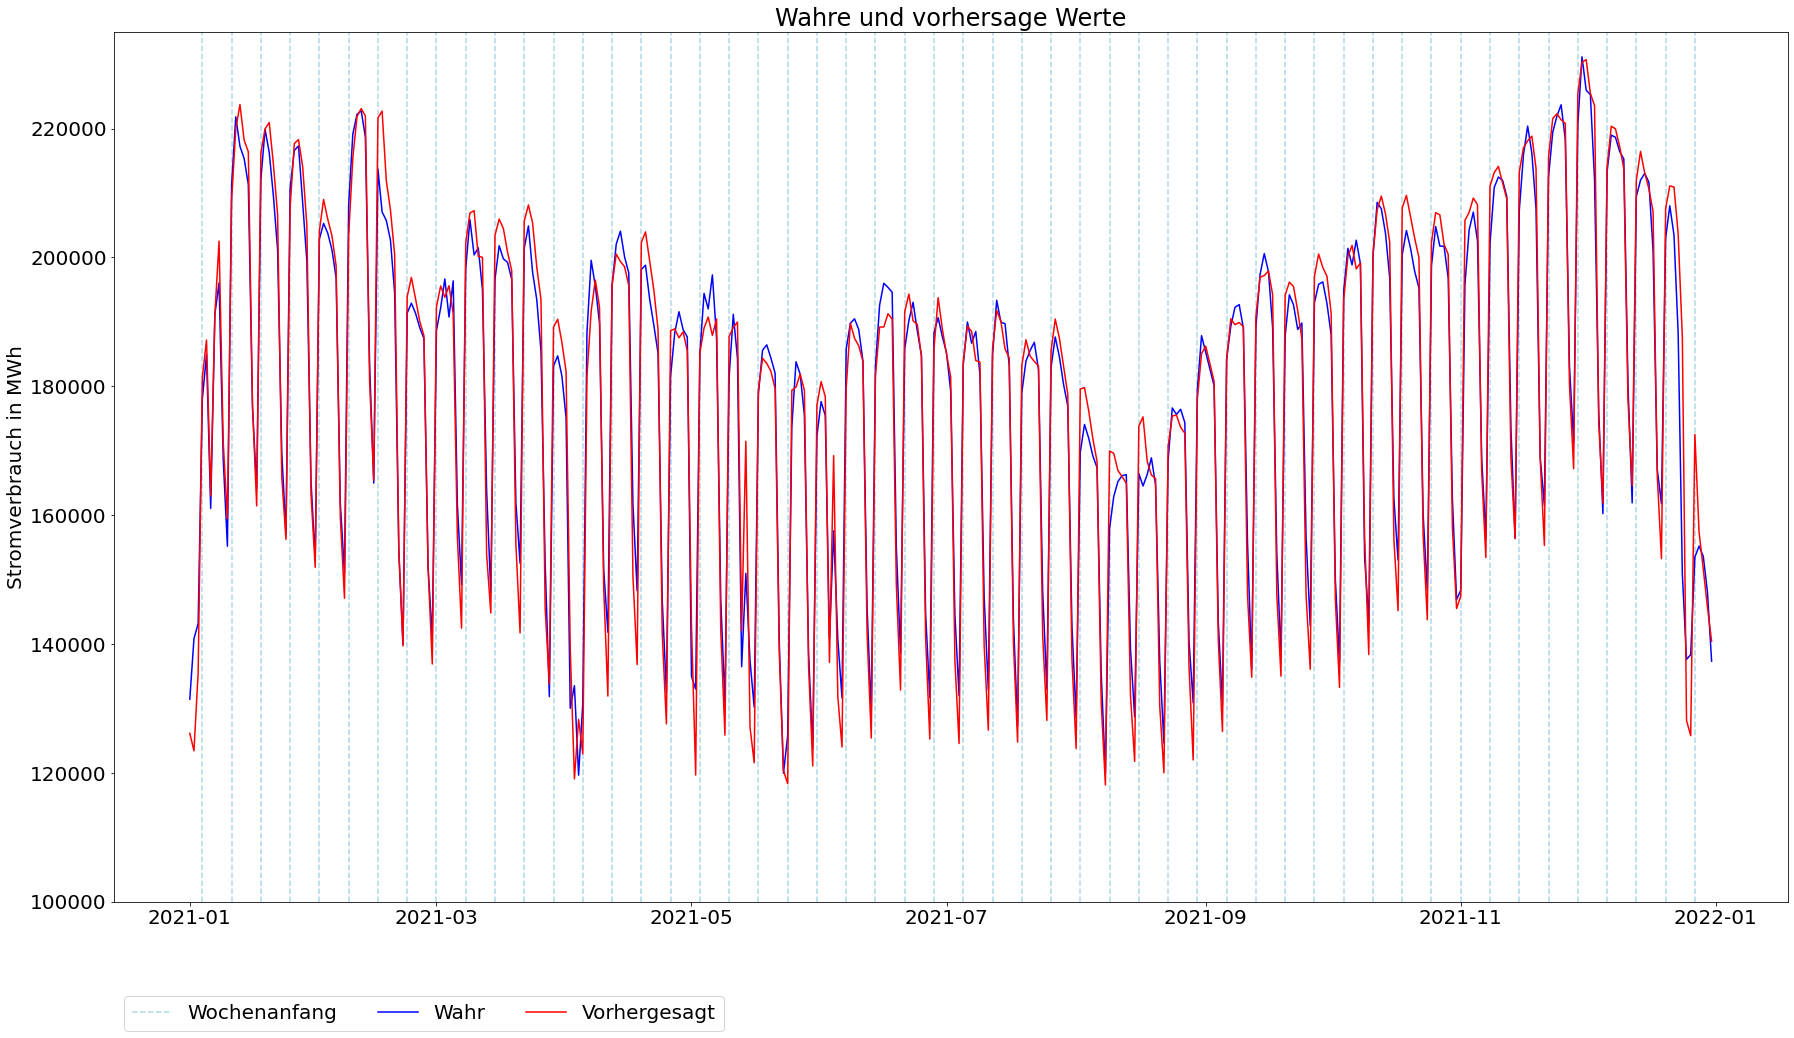

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-5</font><a class="anchor" id="lstm-5"></a>

<font size="5">Es wird nun versucht, das Training mit einer kleineren Batchgröße á 8 und etwas mehr Epochen als bei LSTM-2 zu verbessern.</font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=32, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.35            1.59               1.72
2             2.60            1.67               1.74
3             2.16            1.69               1.78
4             2.43            1.61               1.87
5             2.15            1.85               1.87
Average       2.34            1.68               1.80





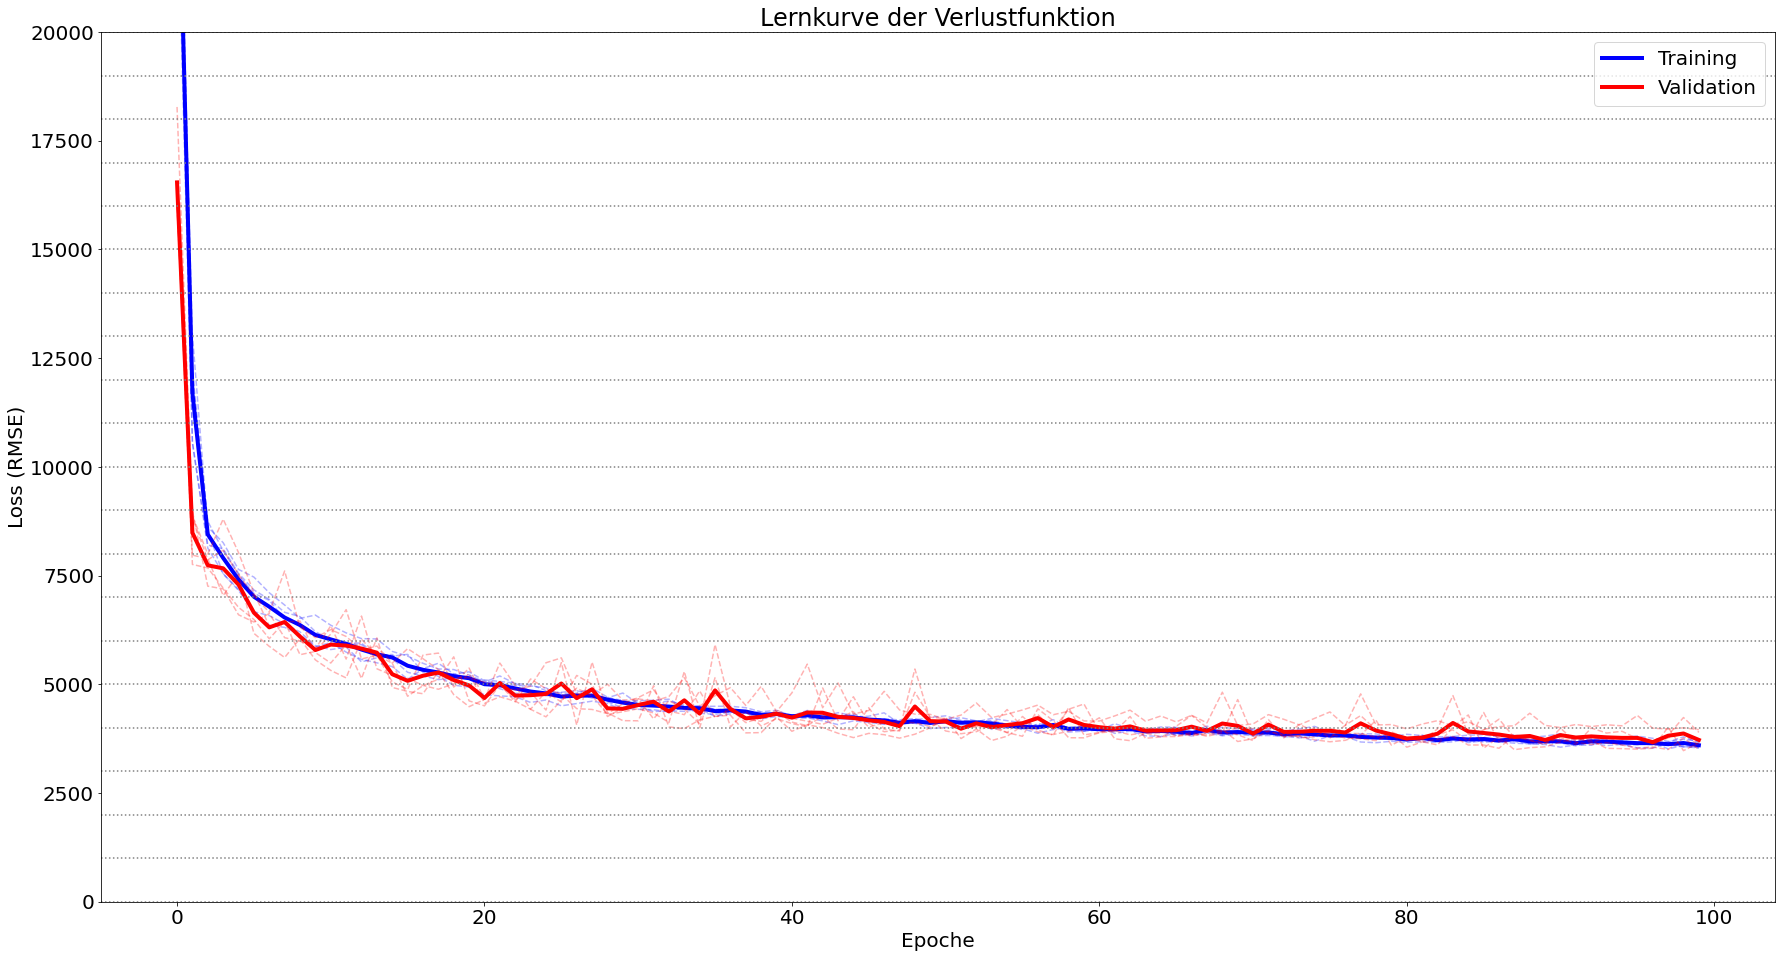

In [10]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Wie schon bei LSTM-2 lernt das Modell sehr schnell und die Konvergenz setzt etwas früher ein. Eine Verbesserung bei der Verlustfunktion ist zunächst nicht zu erkennen. Allerdings setzt die Konvergenz erst sehr spät ein, es könnten also gegebenenfalls mehr Epochen notwendig sein. Davon soll allerdings zunächst abgesehen werden, da es hierdurch zu stärkeren Überanpassungen kommt.
 </font>
<br><br>
<font size="5">
Der MAPE hat sich geringfügig verbessert, aher werden zunächst weiter 8er Batches verwendet. Stattdessen soll die LSTM-Schicht durch weitere Neuronen ergänzt werden, um mehr Potenzial zu schaffen.
</font>

### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 2s 4ms/step - loss: 0.1592
Epoch 2/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0690
Epoch 3/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0602
Epoch 4/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0565
Epoch 5/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0546
Epoch 6/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0505
Epoch 7/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0477
Epoch 8/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0477
Epoch 9/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0458
Epoch 10/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0438
Epoch 11/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0428
Epoch 12/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0424
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       3932.0         2640.0
MSE   26749742.0     14539764.0
RMSE      5172.0         3813.0
                               
MAPE      2.36 %         1.65 %


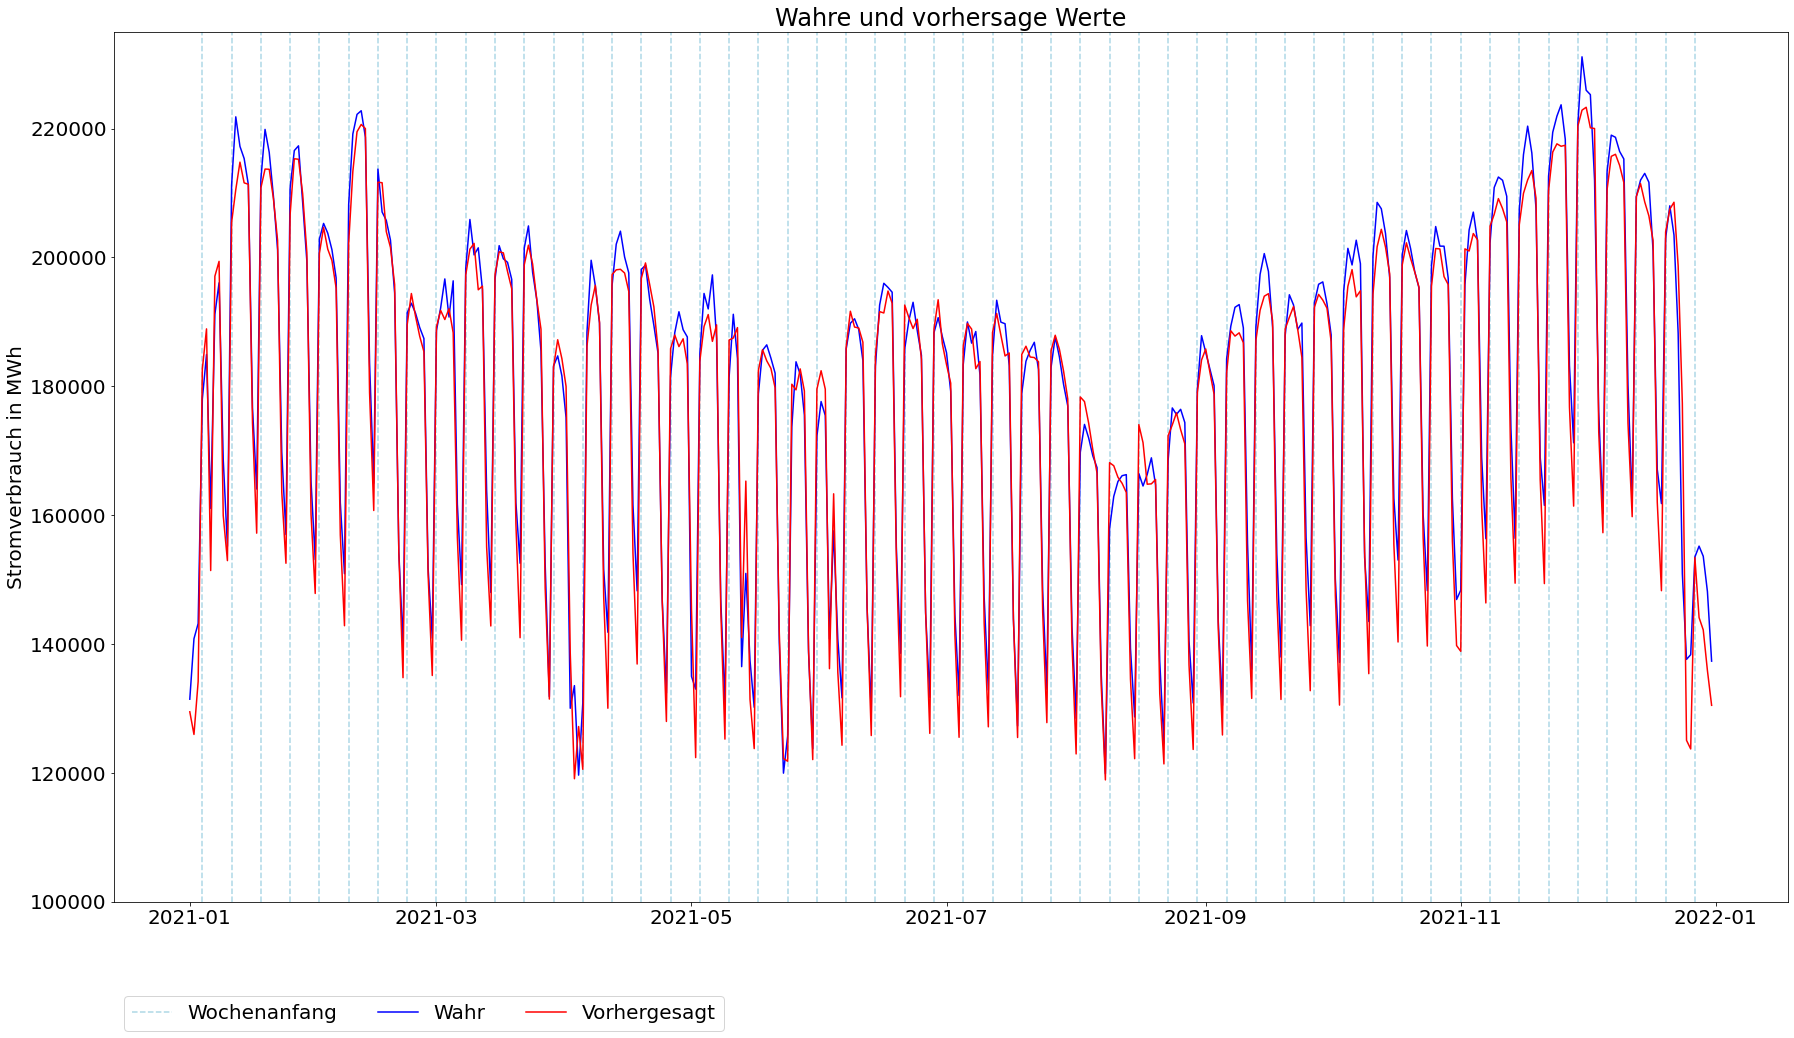

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-6</font><a class="anchor" id="lstm-6"></a>

<font size="5">Die LSTM-Schicht wird durch weitere Neuronen ergänzt, um mehr Potenzial zu erschließen. Dafür werden statt 32 nun 64 Neuronen in die Schicht eingefügt.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.35            1.75               1.93
2             2.52            1.50               1.70
3             2.47            1.44               1.65
4             2.39            1.51               1.86
5             2.38            1.53               1.60
Average       2.42            1.55               1.75





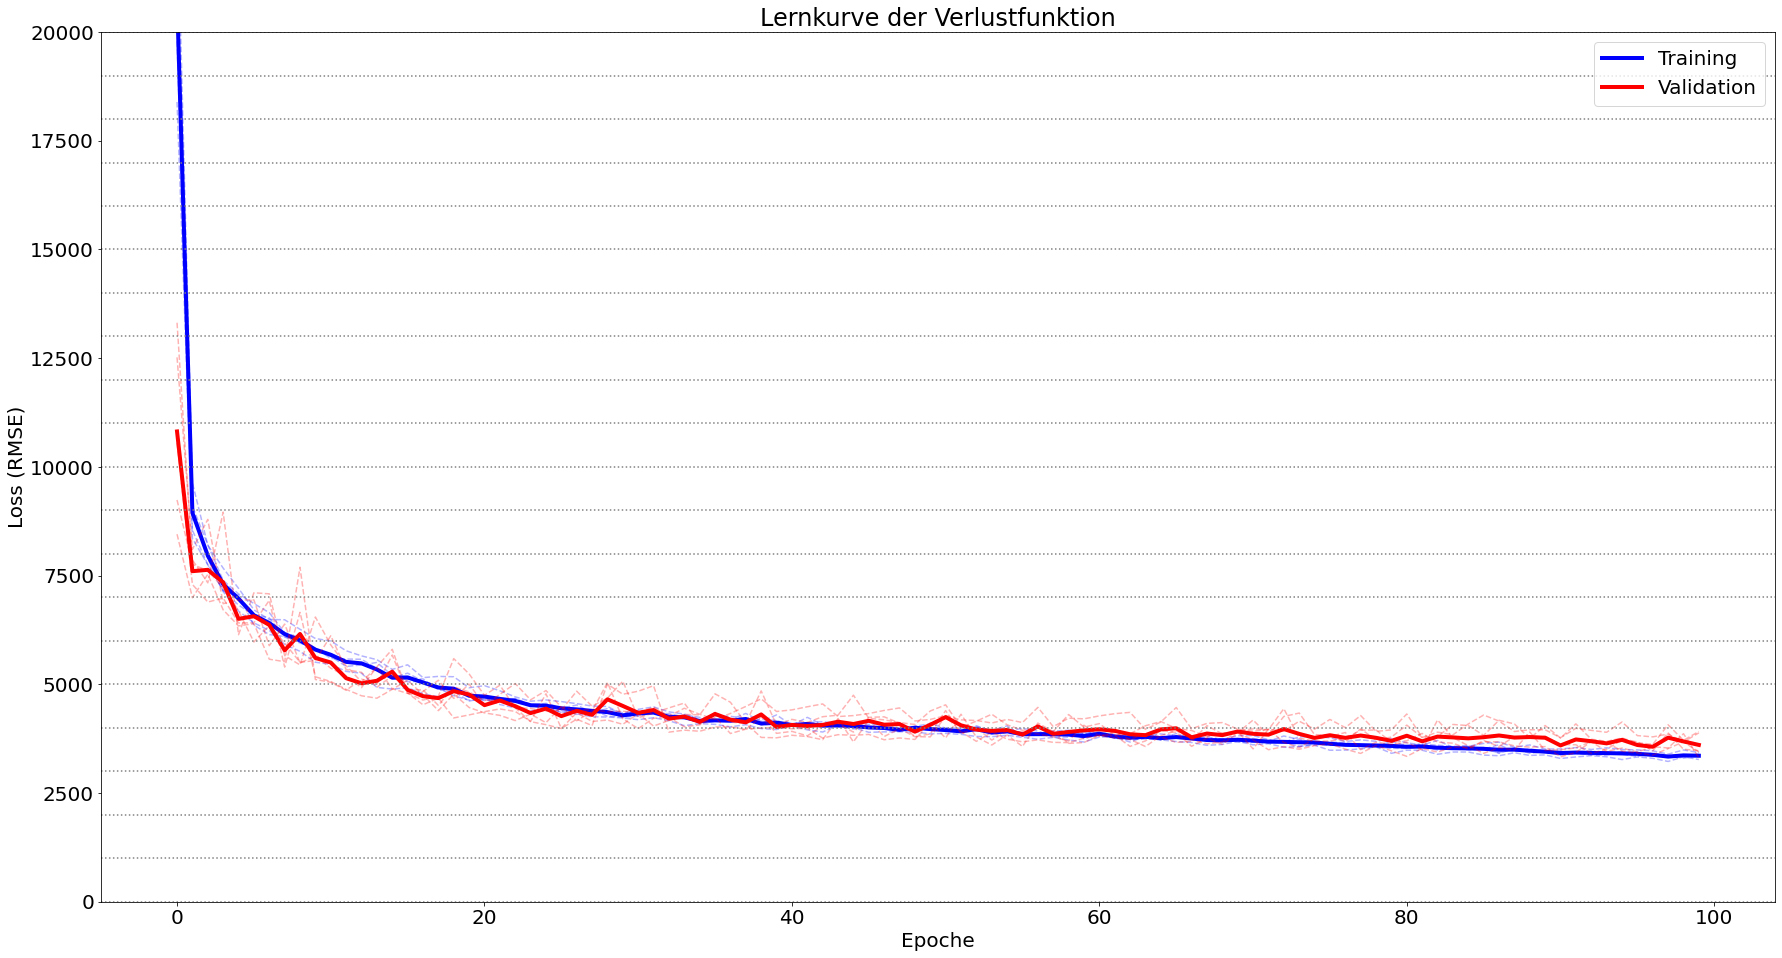

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Das Netz lern weiterhin sehr schnell an, die Konvergenz beginnt ab etwa der 80 Epoche. Allerdings konvergiert die Lernkurve nur bei den Testdaten. Bei den Trainingsdaten führen mehr Epochen zu einer Überanpassung an die Trainingsdaten.
</font>
<br><br>
<font size="5">
Der MAPE sinkt auf den Testdaten auf etwa 2,2%, auf den Trainingsdaten allerdings auf 1,4%. Hier deutet sich also ebenfalls eine Überanpassung an.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 2s 4ms/step - loss: 0.1658
Epoch 2/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0642
Epoch 3/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0575
Epoch 4/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0517
Epoch 5/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0505
Epoch 6/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0472
Epoch 7/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0459
Epoch 8/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0454
Epoch 9/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0436
Epoch 10/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0420
Epoch 11/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0417
Epoch 12/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0396
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.97           0.98
MAE       3642.0         2243.0
MSE   23042014.0     11301258.0
RMSE      4800.0         3362.0
                               
MAPE      2.19 %          1.4 %


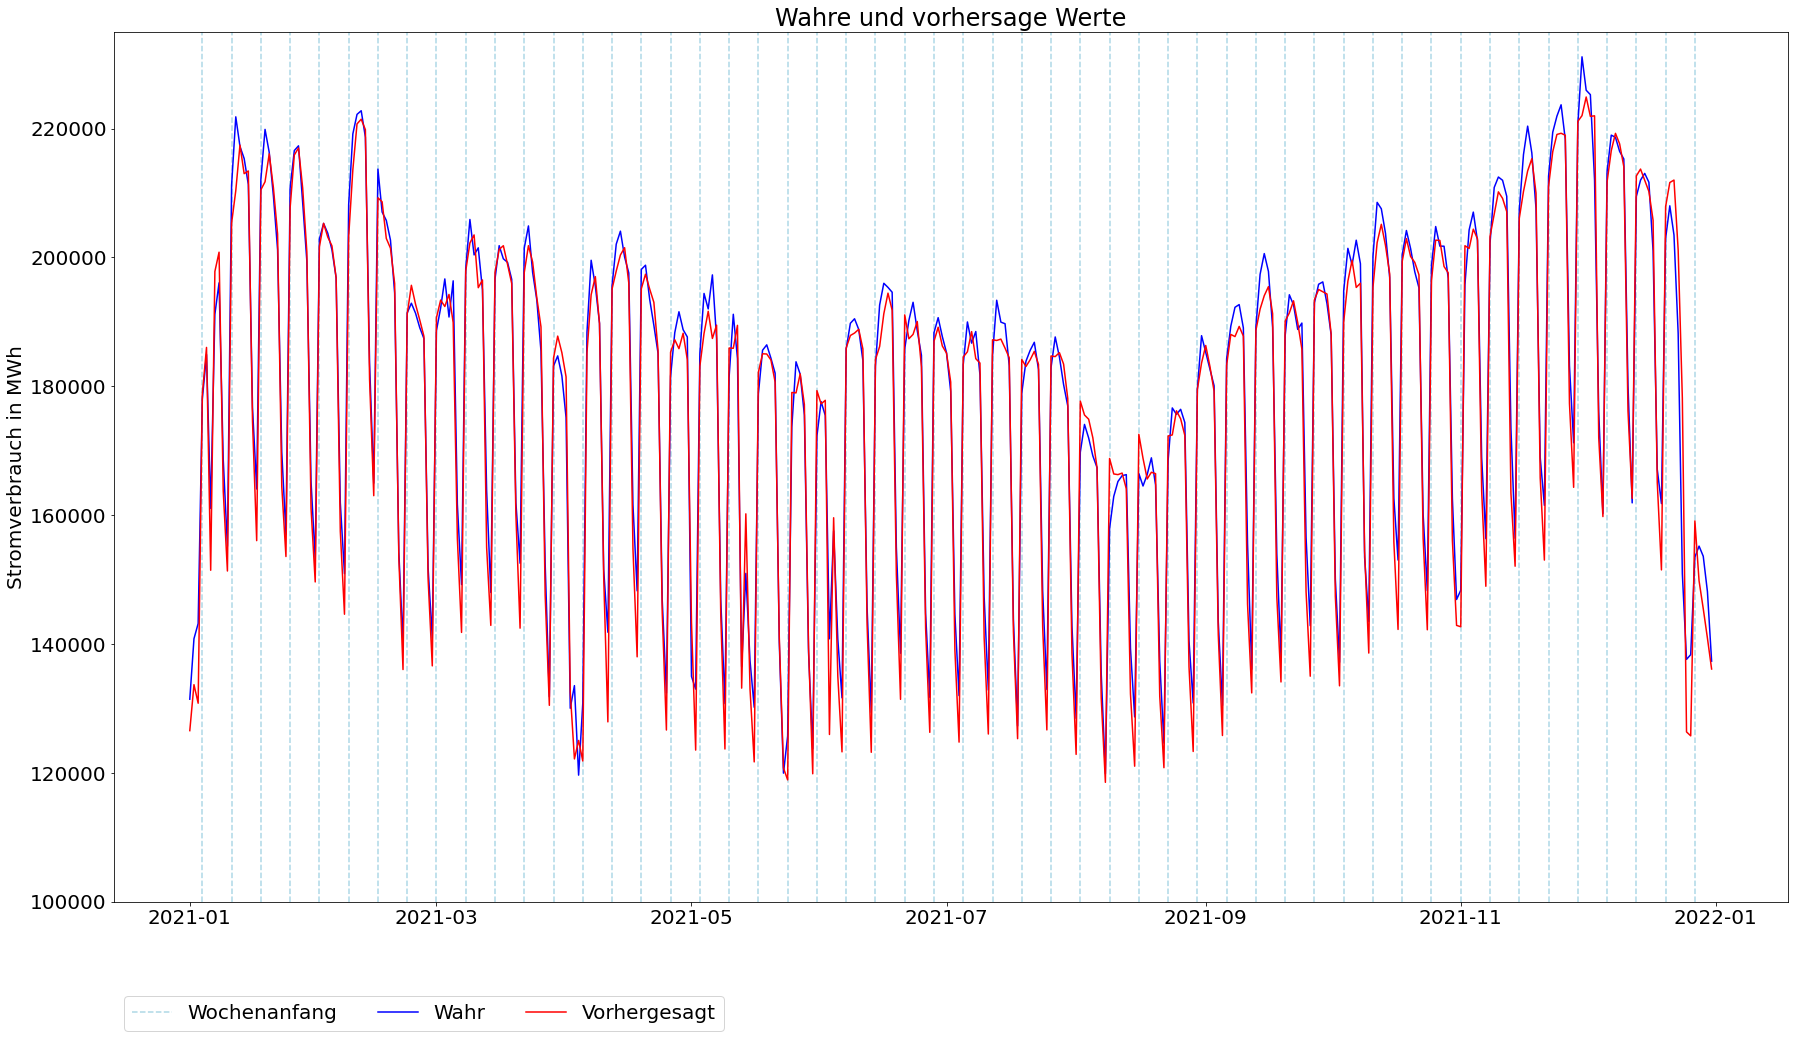

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-7</font><a class="anchor" id="lstm-7"></a>

<font size="5">Die LSTM-Schicht wird durch weitere Neuronen ergänzt, um mehr Potenzial zu erschließen. Dafür werden statt 64 nun 128 Neuronen in die Schicht eingefügt.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=128, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.20            1.56               1.83
2             2.33            1.51               1.77
3             2.01            1.44               1.72
4             2.36            1.49               1.89
5             2.05            1.59               1.74
Average       2.19            1.52               1.79





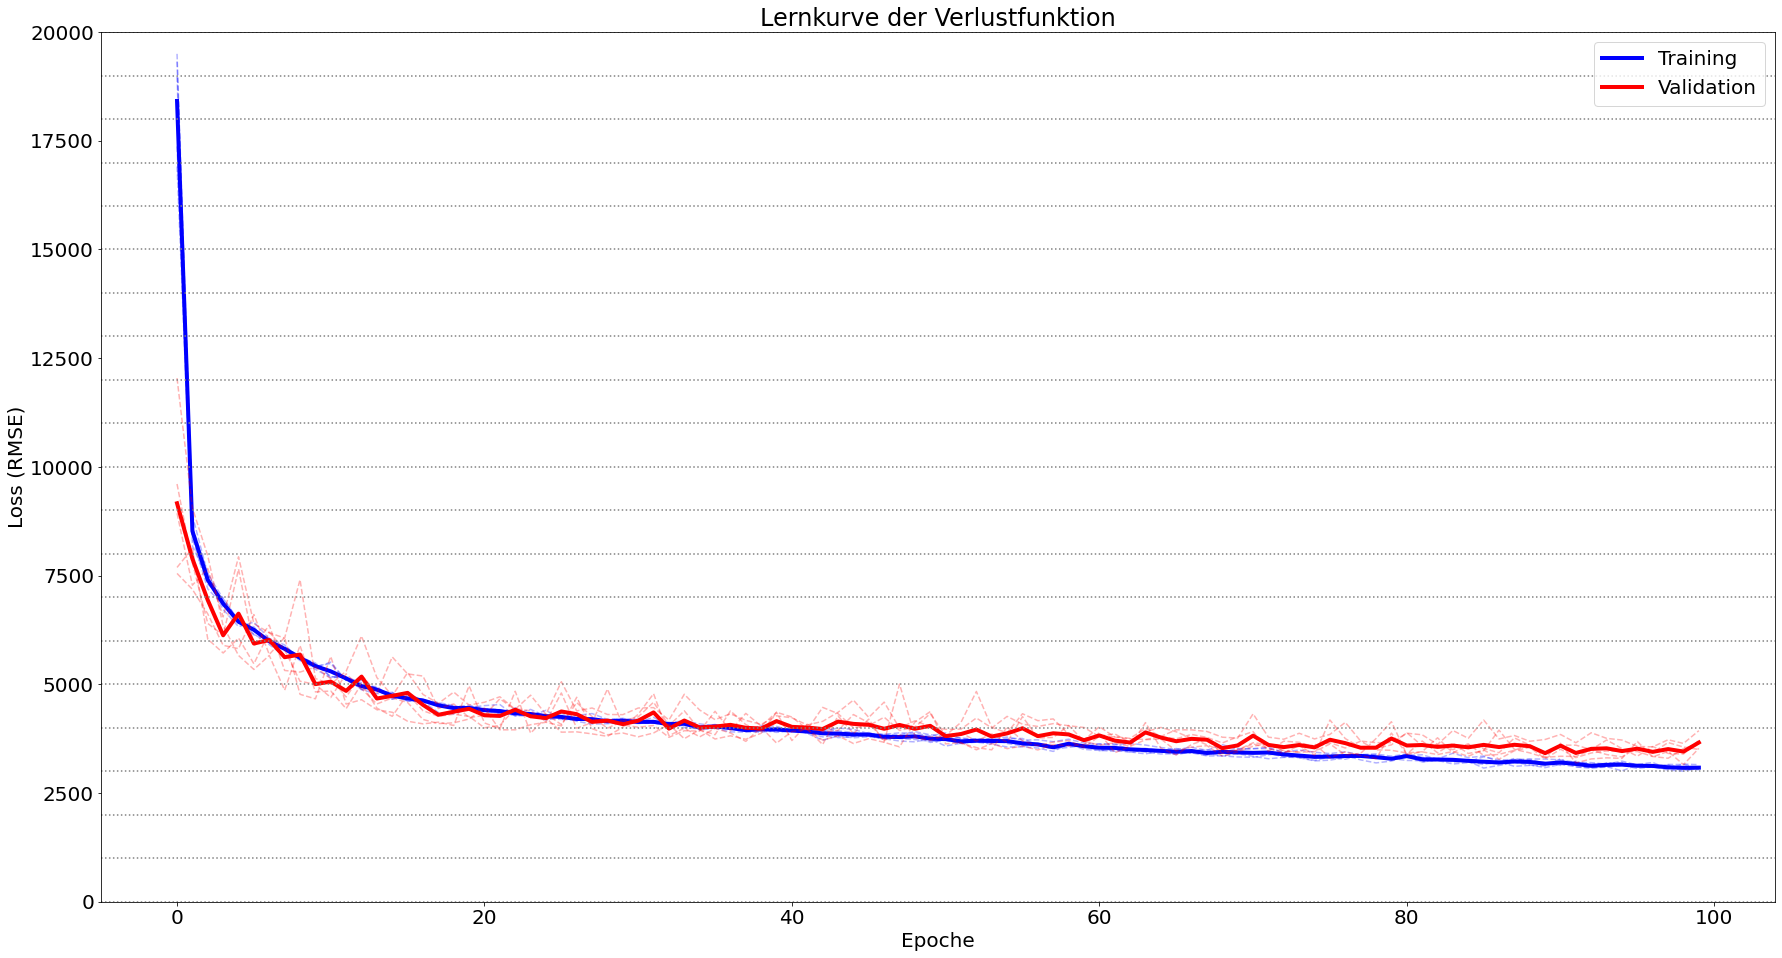

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Die Lernkurve zeigt, dass die Überanpassung ab etwa der 60. Epoche einsetzt.
</font>
<br><br>
<font size="5">
Während der Kreuzvalidierungen lässt sich zwar stellenweise der MAPE auf den Trainingsdaten reduzieren, aber abgesehen davon führen die zusätzlichen Neuronen zu keiner Verbesserung. Von einer Erweiterung auf 128 Neuronen kann also abgesehen werden.
</font>


### <font size="5">Test</font>

In [8]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 3s 6ms/step - loss: 0.1306
Epoch 2/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0634
Epoch 3/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0545
Epoch 4/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0516
Epoch 5/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0477
Epoch 6/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0459
Epoch 7/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0444
Epoch 8/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0432
Epoch 9/100
273/273 [==============================] - 2s 7ms/step - loss: 0.0406
Epoch 10/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0390
Epoch 11/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0381
Epoch 12/100
273/273 [==============================] - 2s 6ms/step - loss: 0.0373
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.97           0.99
MAE       3646.0         2166.0
MSE   23922789.0     10149959.0
RMSE      4891.0         3186.0
                               
MAPE       2.2 %         1.34 %


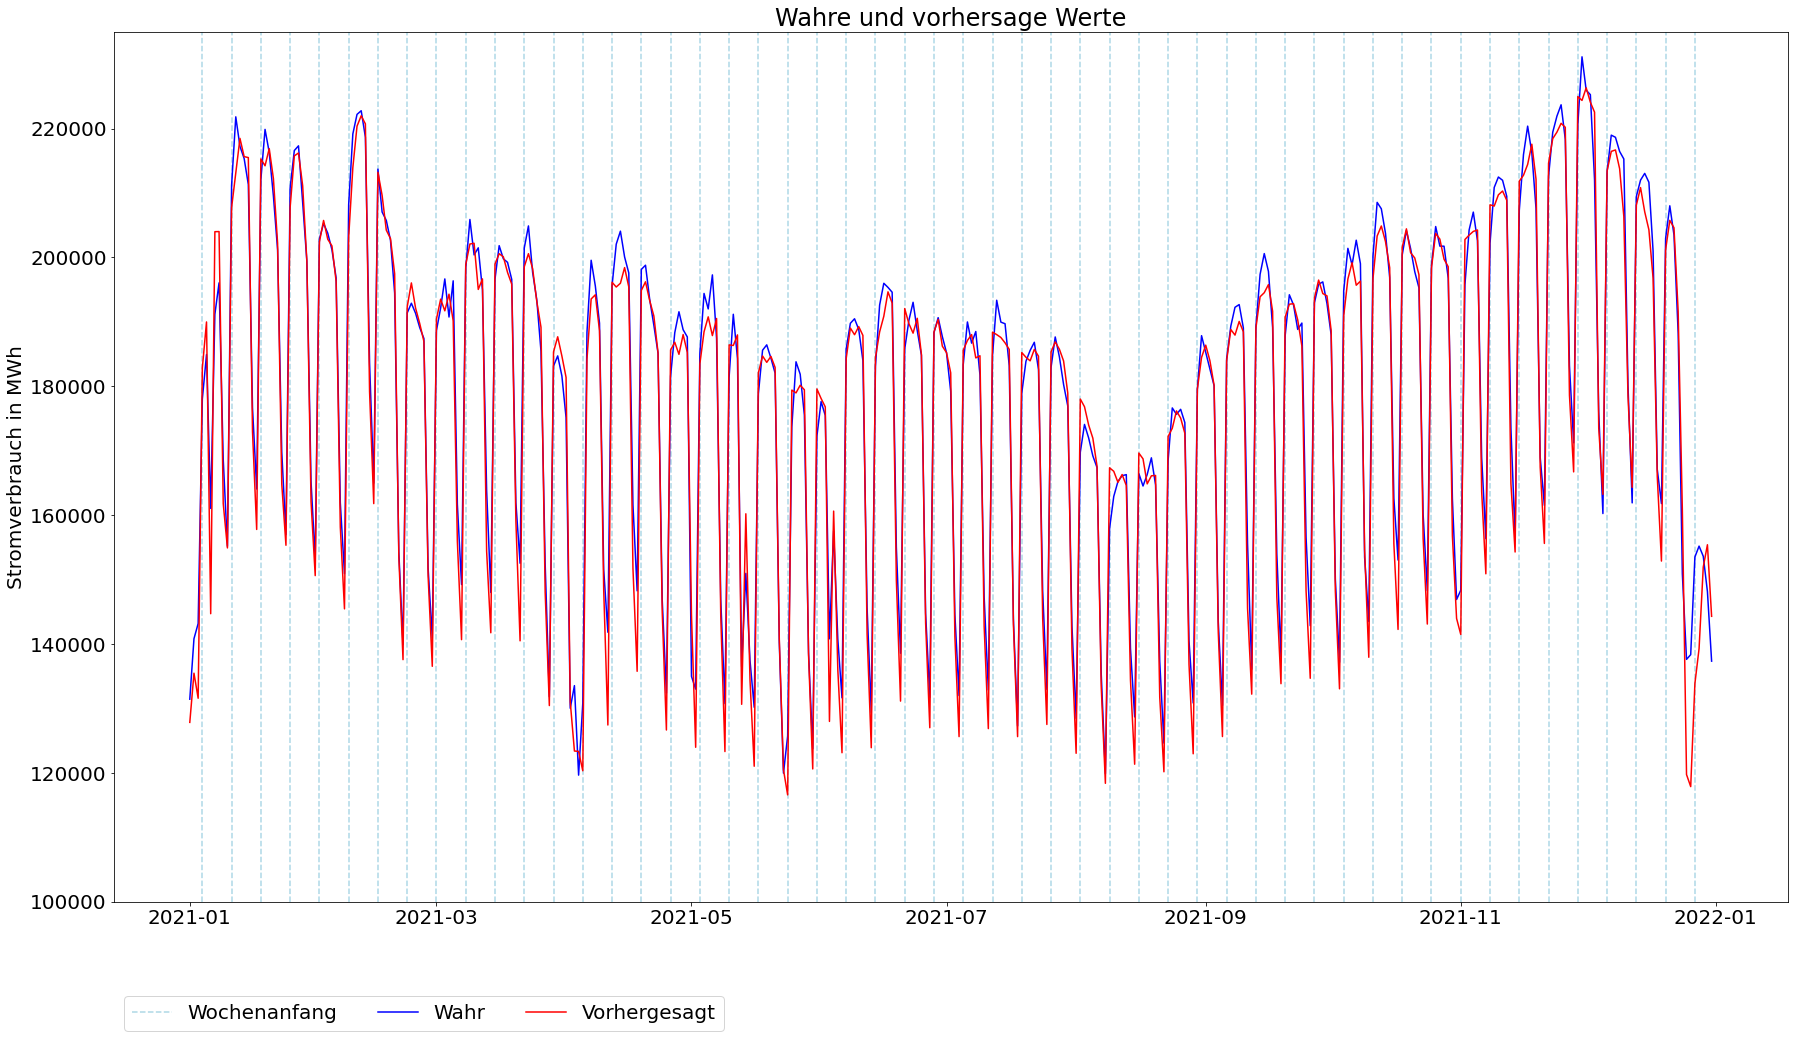

In [9]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-8</font><a class="anchor" id="lstm-8"></a>

<font size="5">Die LSTM-Schicht wird also wieder auf 64 Neuronen reduziert. Stattdessen werden die Batches auf 16 vergrößert.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 16

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.50            1.73               1.89
2             2.30            1.76               1.82
3             2.34            1.67               1.72
4             2.31            1.60               1.91
5             2.55            1.94               2.00
Average       2.40            1.74               1.87





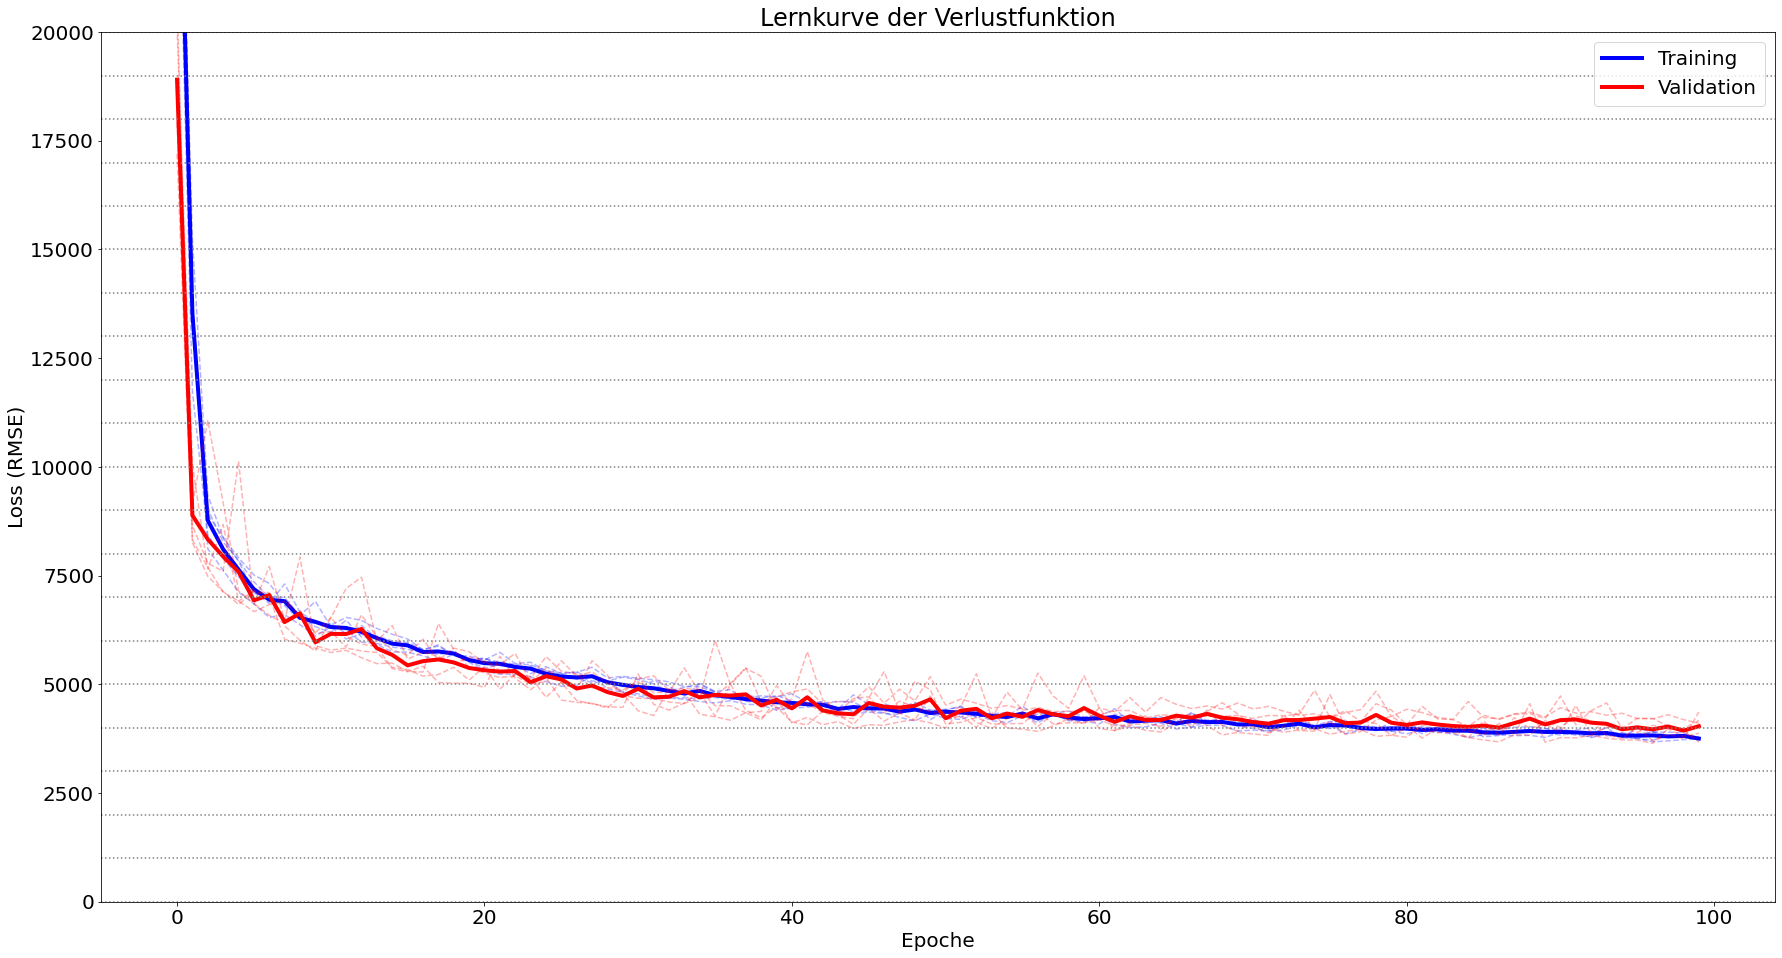

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Das Verhalten der Lernkurve kann durch andere Lernraten nicht verbessert werden und wird daher akzeptiert.
</font>
<br><br>
<font size="5">
Durch eine Veränderung der Batch-Größe lässt sich keine Verbesserung erzielen. Die Qualität nimmt während der Kreuzvalidierungen und während des finalen Tests etwas ab. Die Verlustfunktion bleibt bei 8er Batches also nicht in einem lokalen Minimum hängen.
</font>


### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
137/137 [==============================] - 2s 4ms/step - loss: 0.1957
Epoch 2/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0920
Epoch 3/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0690
Epoch 4/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0614
Epoch 5/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0580
Epoch 6/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0546
Epoch 7/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0538
Epoch 8/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0502
Epoch 9/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0501
Epoch 10/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0492
Epoch 11/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0496
Epoch 12/100
137/137 [==============================] - 1s 4ms/step - loss: 0.0464
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       4026.0         2686.0
MSE   28934732.0     14786249.0
RMSE      5379.0         3845.0
                               
MAPE      2.47 %         1.67 %


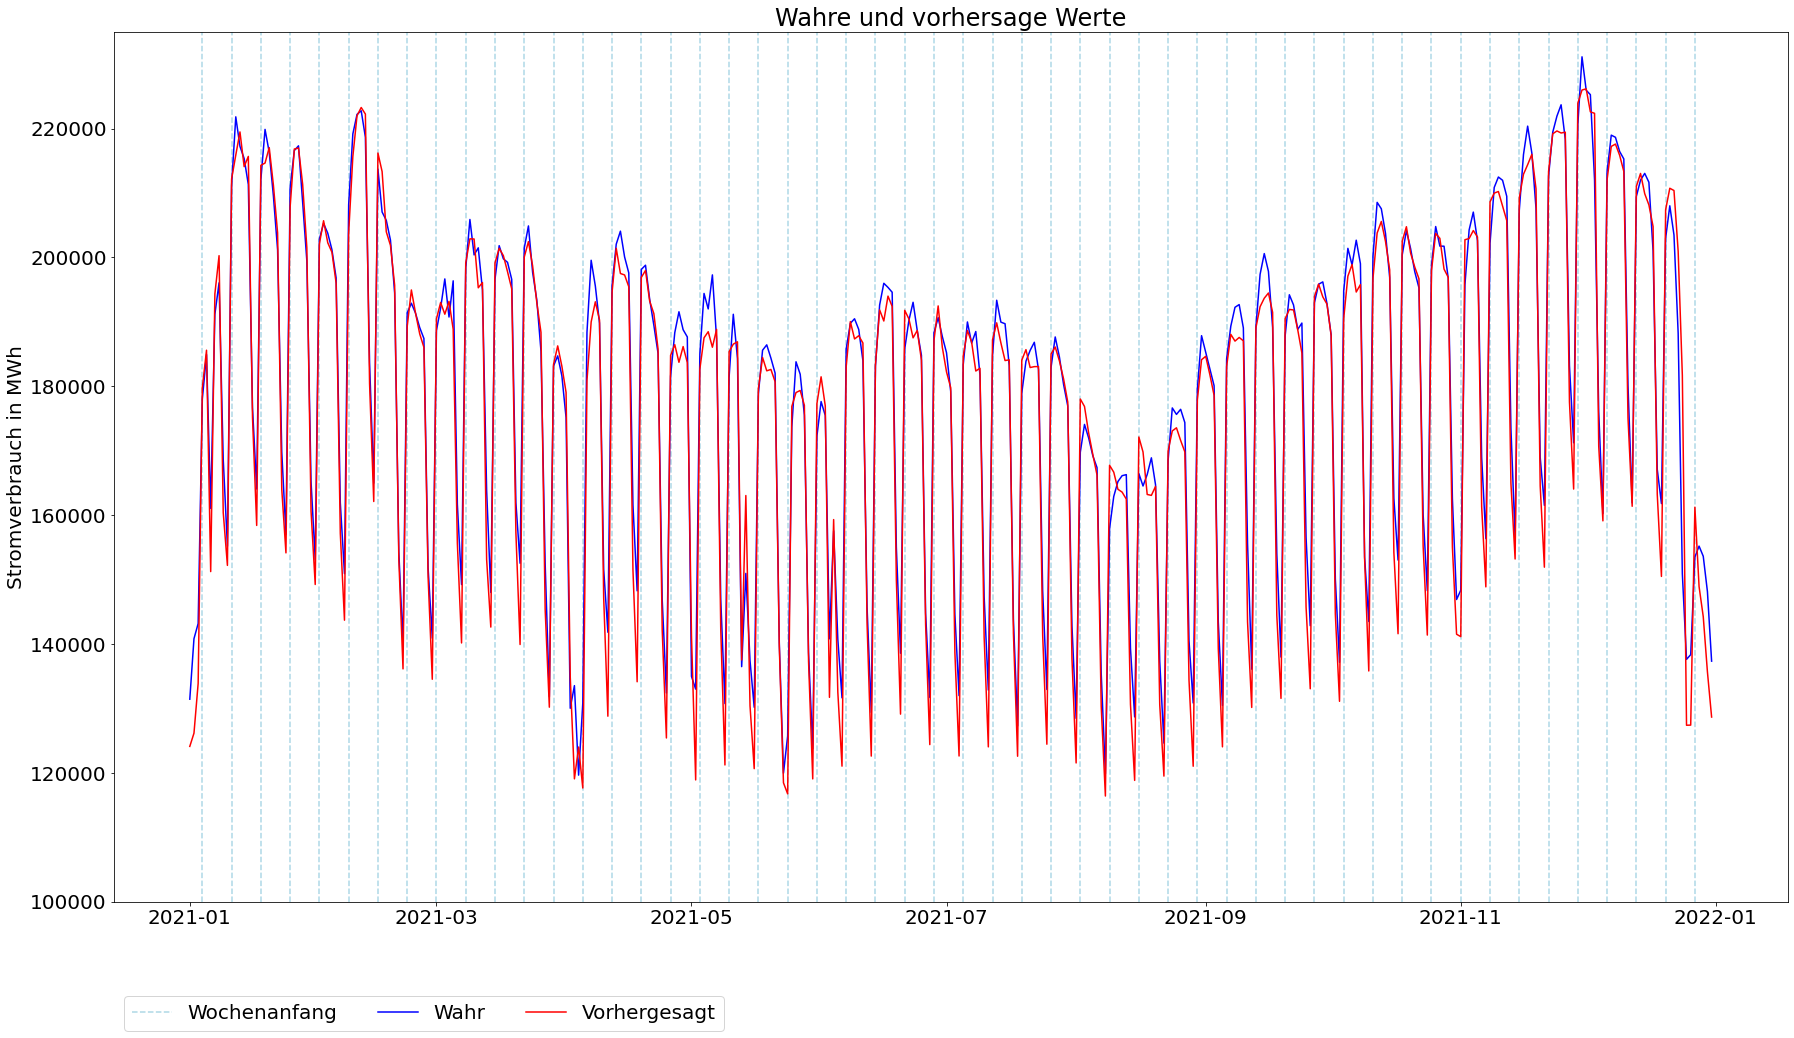

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-9</font><a class="anchor" id="lstm-9"></a>

<font size="5">Bisher wurde in allen Netzen die Tanh-Funktion zur Aktivierung verwendet, da sie vor Allem in flachen Netzen sehr gute Ergebnisse erzielt. Allerdings bietet es sich trotzdem an, die ReLu-Funktion testweise einzusetzen.<font>

### <font size="5">Modell und Parameter</font>

In [2]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    model.add(LSTM(units=64, return_sequences=False, activation="relu"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [3]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [4]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.37            1.38               1.62
2             2.19            1.56               1.74
3             2.13            1.40               1.59
4             2.01            1.38               1.73
5             2.32            1.41               1.67
Average       2.20            1.43               1.67





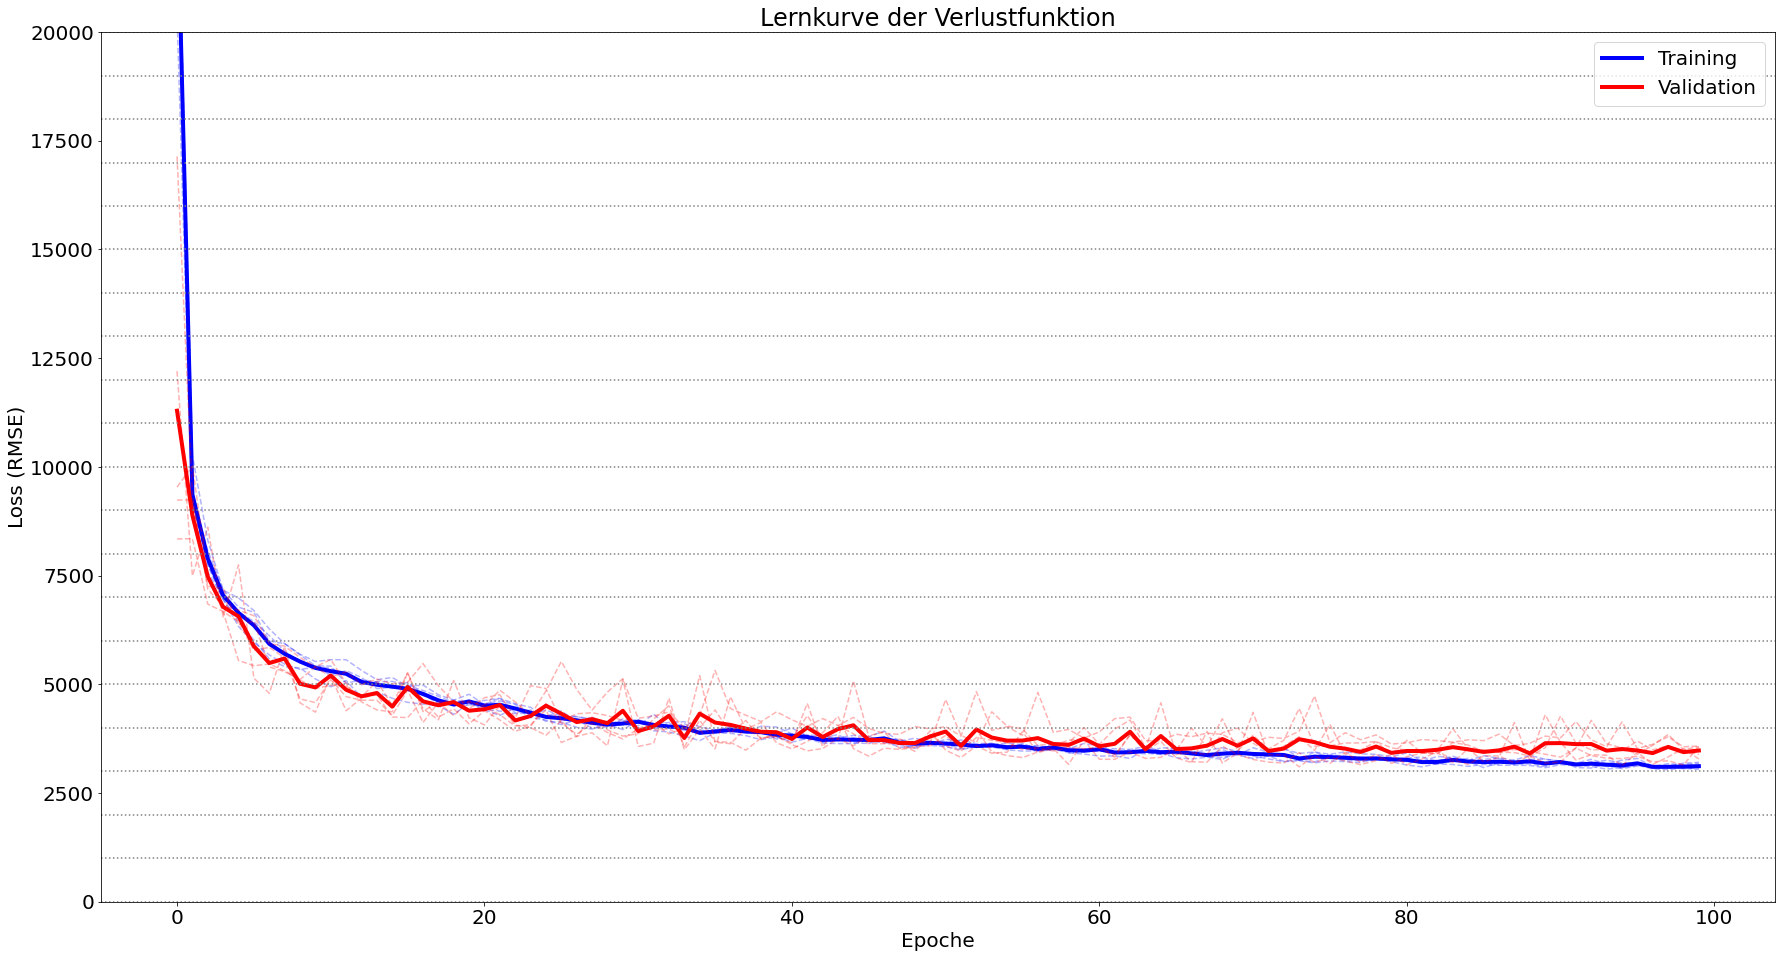

In [5]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Der Einsatz der ReLu-Funktion bringt im Vergleich zu Tanh keine sonderlich großen Verbesserungen. Die Lernkurve läuft ähnlich und auch die Metriken verbessern sich nur geringfügig.
</font>

### <font size="5">Test</font>

In [6]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 2s 3ms/step - loss: 0.1436
Epoch 2/100
273/273 [==============================] - 1s 4ms/step - loss: 0.0646
Epoch 3/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0593
Epoch 4/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0538
Epoch 5/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0495
Epoch 6/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0466
Epoch 7/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0449
Epoch 8/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0447
Epoch 9/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0426
Epoch 10/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0416
Epoch 11/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0399
Epoch 12/100
273/273 [==============================] - 1s 3ms/step - loss: 0.0403
Epoch 13/100


       Testdaten Trainingsdaten
R2          0.96           0.99
MAE       3807.0         2211.0
MSE   25884008.0     10062090.0
RMSE      5088.0         3172.0
                               
MAPE       2.3 %         1.37 %


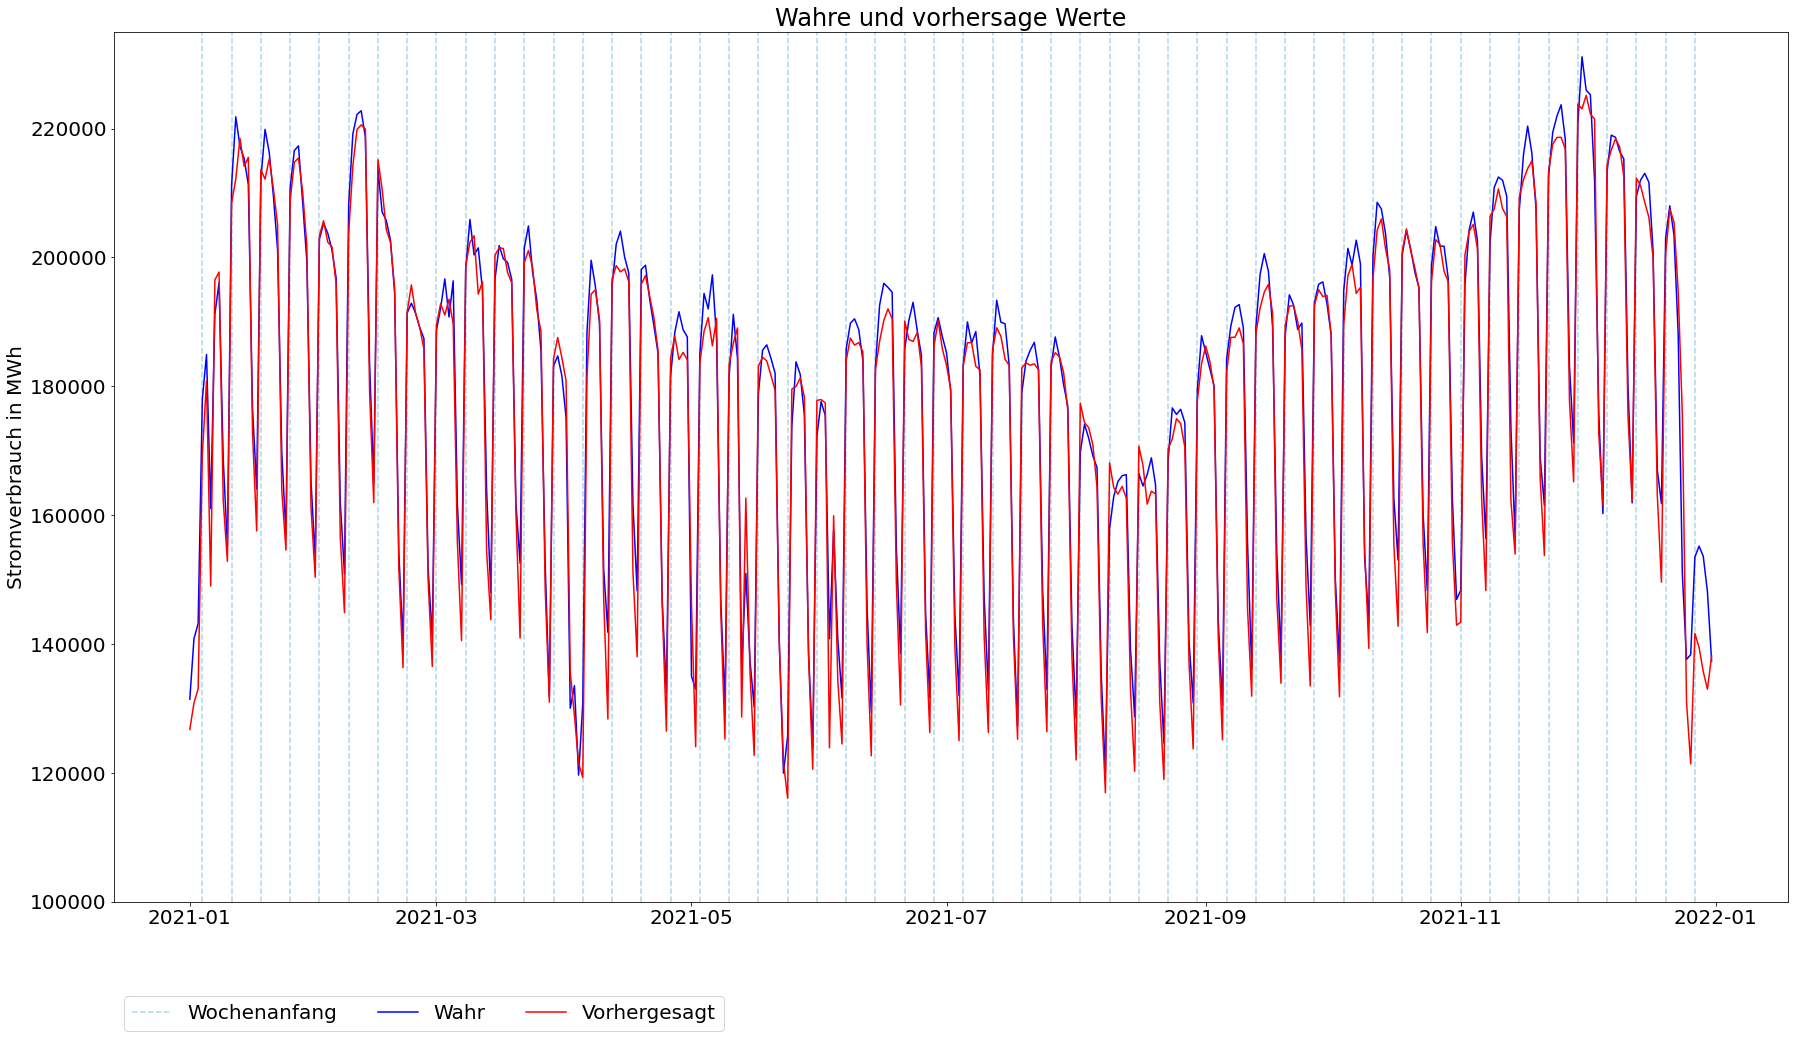

In [7]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)

## <font size="7">LSTM-10</font><a class="anchor" id="lstm-10"></a>

<font size="5">Da sich die umfangreichen Netze leicht überanpassen, wir im Folgenden eine Regularisierung in das LSTM-6-Netz eingefügt.<font>

### <font size="5">Modell und Parameter</font>

In [7]:
#Hyperparameter
epochs = 100
batch_size = 8

window_size = 14

def model_creation():
    
    #Modell erstellen
    model = Sequential()
    model.add(InputLayer(input_shape=(window_size, 4)))
    
    regularizer = l2(0.001)
    
    model.add(LSTM(units=64, kernel_regularizer=regularizer, return_sequences=False, activation="tanh"))
    
    model.add(Dense(units=1))

    adam = Adam(learning_rate=0.0005)

    model.compile(loss=root_mean_squared_error, optimizer=adam)
    
    return model

### <font size="5">Daten laden</font>

In [5]:
#Unskalierte Daten für Analysen laden
df_unscaled = pd.read_csv("../3-Data Preparation/data.csv", index_col=0, parse_dates=True)
df_unscaled.index.freq = "D"

y_test_true = df_unscaled["verbrauch"]["2021-01-01":]
y_train_true = df_unscaled["verbrauch"][window_size:2192]

#Skalierte Daten für Modellierung laden
df_scaled = pd.read_csv("../3-Data Preparation/data_scaled.csv", index_col=0, parse_dates=True)
df_scaled.index.freq = "D"

#Aufteilung X (Merkmale) und y (Ziel)
X = df_scaled[["verbrauch","arbeitstag","temperatur","tagesstunden"]]
#Stromverbrauch wird bei X um eine Stelle nach vorne verschoben, daher entfällt der 01.01.2015
X["arbeitstag"] = X["arbeitstag"].shift(-1)
X["temperatur"] = X["temperatur"].shift(-1)
X["tagesstunden"] = X["tagesstunden"].shift(-1)
X = X[:2556]

y = df_scaled["verbrauch"]

#Aufteilung der Daten in Zeitfenster
def restructure_data(px, py, window_size):
    
    X_, y_ = [], []
    
    idx_range = range(len(px) - (window_size) + 1)
    
    for idx in idx_range:
        X_.append(px[idx:idx+window_size])
        y_.append(py[idx+window_size])
        
    X_ = np.array(X_)
    y_ = np.array(y_)
    
    return X_, y_

X_windows, y_windows = restructure_data(X, y, window_size)

#Aufteilung in Trainings-, Validierungs- und Testdaten
split_by = 2557 - 365 - window_size

X_train = X_windows[:split_by]
y_train = y_windows[:split_by]

X_test = X_windows[split_by:]
y_test = y_windows[split_by:]

### <font size="5">Training</font>

In [8]:
#Kreuzvalidierung erstellen
kfold = KFold(n_splits=5, shuffle=True, random_state=0)

#DataFrames für History und Metriken
df_history = pd.DataFrame()
df_history.index.name = "Epoch"

df_metrics = pd.DataFrame(columns=["Testdaten", "Trainingsdaten", "Validierungsdaten"])
df_metrics.index.name = "Split"

iteration = 1

scaler_target = joblib.load("../3-Data Preparation/scaler_endog.save")

#Kreuzvalidierung
for train_index, validation_index in kfold.split(X_train, y_train):
    
    print(iteration, "-", end="\t")
    
    #Modell erstellen
    model = model_creation()
    
    #Modell trainieren
    history = model.fit(x=X_train[train_index], y=y_train[train_index], epochs=epochs, batch_size=batch_size, validation_data=(X_train[validation_index], y_train[validation_index]), verbose=0)
    
    #Ergebnisse speichern
    df_history[str(iteration) + "_train_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["loss"]).reshape(-1, 1)) - 102469)).squeeze()
    df_history[str(iteration) + "_validation_loss"] = pd.DataFrame(data=(scaler_target.inverse_transform(np.array(history.history["val_loss"]).reshape(-1, 1)) - 102469)).squeeze()
    
    #Vorhersagen für Test-, Trainings- und Validierungsdaten
    preds_test = scaler_target.inverse_transform(model.predict(X_test).reshape(-1, 1))
    preds_train = scaler_target.inverse_transform(model.predict(X_train[train_index]).reshape(-1, 1))
    preds_validation = scaler_target.inverse_transform(model.predict(X_train[validation_index]).reshape(-1, 1))
    
    df_metrics.loc[iteration] = [round(metrics.mean_absolute_percentage_error(y_test_true, preds_test) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[train_index], preds_train) * 100, 2),
                                 round(metrics.mean_absolute_percentage_error(y_train_true[validation_index], preds_validation) * 100, 2)]
    
    iteration = iteration + 1

#Durchschnittswerte bei History und Metriken berechnen
df_history["train_loss"] = (df_history["1_train_loss"] + df_history["2_train_loss"] + df_history["3_train_loss"] + df_history["4_train_loss"] + df_history["5_train_loss"]) / 5
df_history["validation_loss"] = (df_history["1_validation_loss"] + df_history["2_validation_loss"] + df_history["3_validation_loss"] + df_history["4_validation_loss"] + df_history["5_validation_loss"]) / 5

df_metrics.loc["Average"] = [round(df_metrics["Testdaten"].mean(), 2),
                             round(df_metrics["Trainingsdaten"].mean(), 2),
                             round(df_metrics["Validierungsdaten"].mean(), 2)]

1 -	2 -	3 -	4 -	5 -	

### <font size="5">Auswertung des Trainings</font>

         Testdaten  Trainingsdaten  Validierungsdaten
Split                                                
1             2.28            1.61               1.75
2             2.26            1.66               1.76
3             2.47            1.66               1.70
4             2.44            1.56               1.86
5             2.11            1.73               1.82
Average       2.31            1.64               1.78





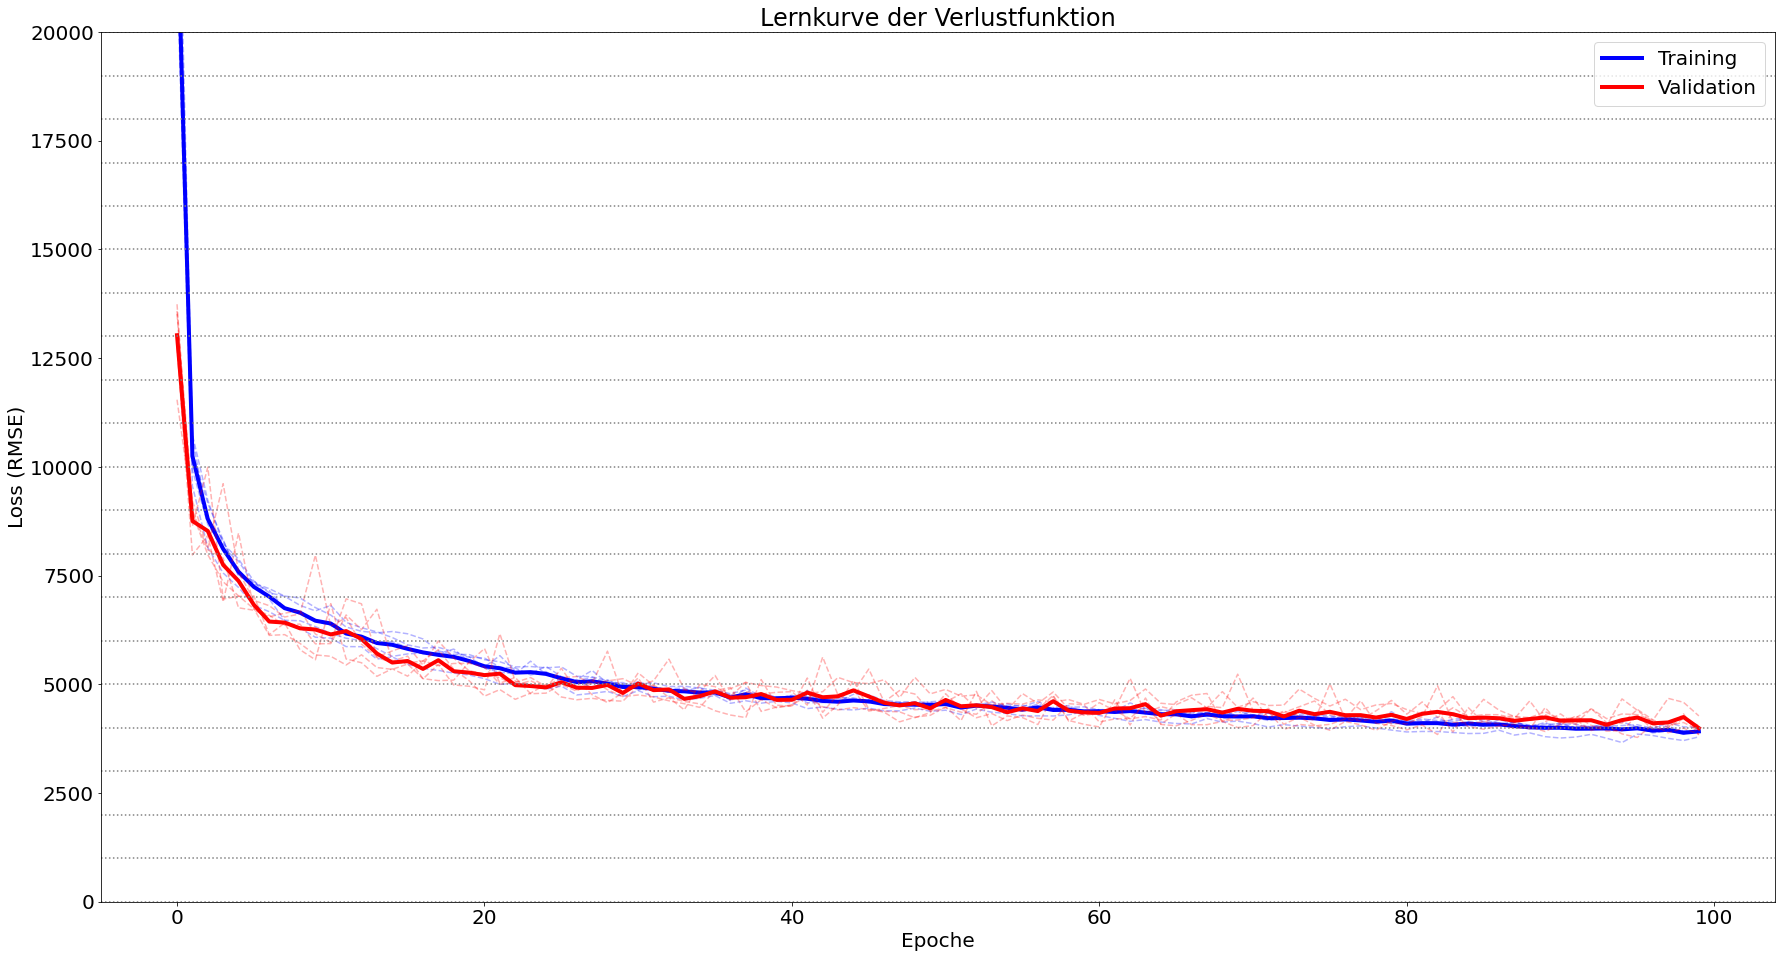

In [9]:
#Training auswerten (Metriken und Lernkurve)
functions.evaluate_training(df_metrics, df_history, 20000)

<font size="5">
Selbst eine leichte Regularisierung führt zu einer Unteranpassung. Das Modell hat sein Potenzial zur Generalisierung also ausgeschöpft.
</font>


### <font size="5">Test</font>

In [10]:
#Finales Modell erstellen
model = model_creation()

#Finales Modell trainieren
history = model.fit(x=X_train, y=y_train, epochs=epochs, batch_size=batch_size, use_multiprocessing=True)

Epoch 1/100
273/273 [==============================] - 3s 5ms/step - loss: 0.1444
Epoch 2/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0702
Epoch 3/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0654
Epoch 4/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0592
Epoch 5/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0577
Epoch 6/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0536
Epoch 7/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0521A: 0
Epoch 8/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0508
Epoch 9/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0493
Epoch 10/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0476
Epoch 11/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0479
Epoch 12/100
273/273 [==============================] - 1s 5ms/step - loss: 0.0456
Epoch 13/

       Testdaten Trainingsdaten
R2          0.96           0.98
MAE       3991.0         2744.0
MSE   28029803.0     14828805.0
RMSE      5294.0         3851.0
                               
MAPE      2.42 %          1.7 %


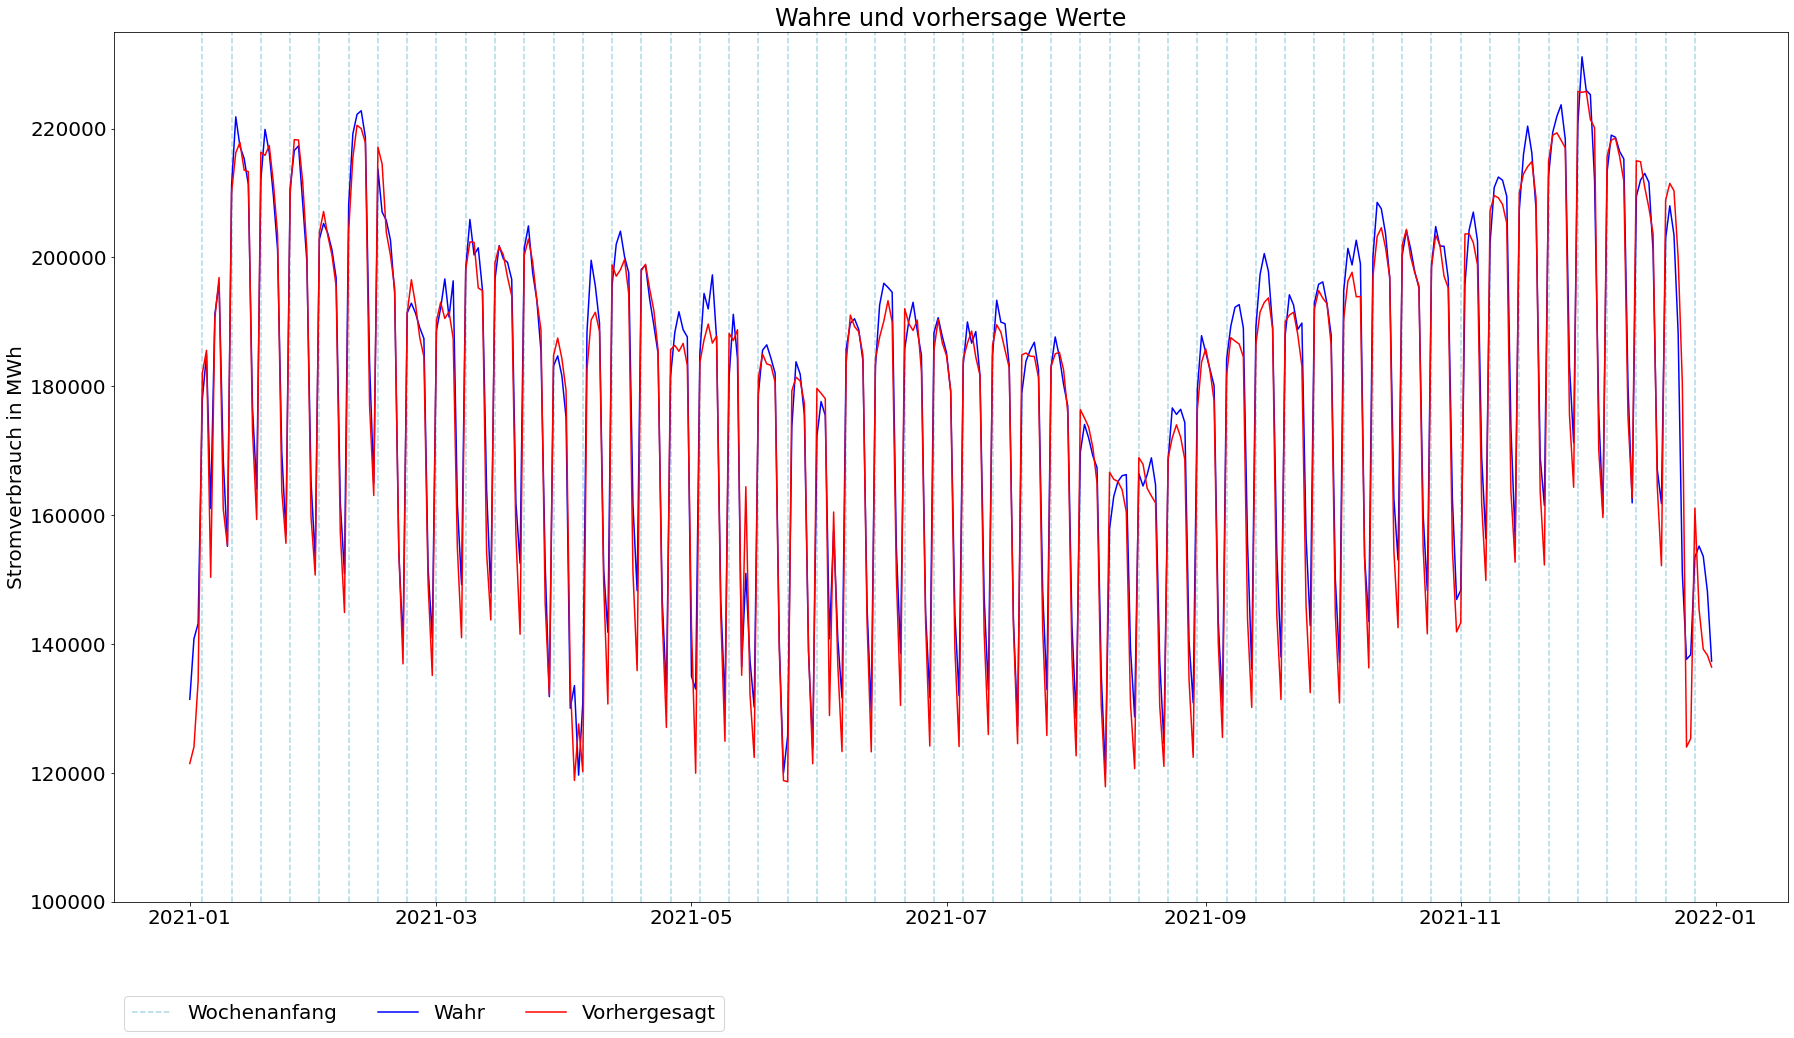

In [11]:
#Vorhersagen erzeugen
scaled_preds_test = model.predict(X_test)
scaled_preds_train = model.predict(X_train)

functions.custom_metrics_lstm(y_test_true, scaled_preds_test, y_train_true, scaled_preds_train)